## <center>Summer 2020 ISMT S-117  Final Project</center>
## <center>To be or not to be Shakespeare?</center>
### <center>Student Name: Haitao Shang</center>

<span style="color:blue">
    At the beginning, I import the modules will be used in this project.

In [1]:
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'transformers', 'nltk', 'gensim'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
import boto
import re
import string
import math
import spacy

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from numpy import log
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from spacy.lang.en import English 
nlp = English()
stopwords = spacy.lang.en.stop_words.STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<span style="color:blue">
    The below piece of code is just to avoid the scroll in the subsequent plots, because there are going to be multiple figures with a number of rows, each row with a couple of plots
</span>

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0) Inroduction

<span style="color:blue">
    In this proiject I will explore if the author of Shakespeare's plays is a single genius or a group of playwrights. We will first explore the basic structure and texts in this dataset, and then process the texts using NLP techniques to get a better understanding of the dataset. Then we will use some machine learning techniques to explore if Shakespeare is one person or a group of people. Indeed there is some risk to use the NLP techniques to study this question, because it is possible that these plays will be classified into two categories: comedy and tragedy. However, we do not know if a technique is useful or not before trying it. As shown in the following analyses, my results show that the plays are NOT simply classified into two categories (comedy and tragedy) when using several different machine learning methods. Although we can neither conclude that the methods I use provide the best (or even right) results nor obtain a final conclusion on the question that whether Shakespeare is one person or a group of people, these attempts probably give us a new perspctive to investigate similar problems. And the analyses I perform in this study may be extended to a useful package for library managers and readers who need to classify book categories.        
</span>

# 1) Initial Exploration the Dataset

In [35]:
# Read the csv file from disk
data_exploration = pd.read_csv('./Shakespeare_Plays_Data/Shakespeare_data.csv', encoding='latin1')
data_exploration

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
...,...,...,...,...,...,...
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first
111394,111395,A Winters Tale,38.0,5.3.183,LEONTES,We were dissever'd: hastily lead away.


<span style="color:blue">
The original dataset "Shakespeare_data.csv" from Kaggle (https://www.kaggle.com/kingburrito666/shakespeare-plays) does not include the information of (i) the year in which a play was written and (ii) the category of a play (that is, comedy, tragedy and history). Therefore, I collected the related information and construct a dataset "Shakespeare_play_category.csv". Using the following "add_additional_play_information" function. I will add the new information in the dataset "dataset "Shakespeare_play_category.csv" to the original dataset "Shakespeare_data.csv".
</span>

In [36]:
def add_additional_play_information(plays_df):
    category_dict = pd.read_csv("./Shakespeare_Plays_Data/Shakespeare_play_category.csv", index_col=0, squeeze=True, header=None).to_dict()

    plays_df['PlayYear'] = plays_df['Play'].map(category_dict.get(1))
    plays_df['PlayCategory'] = plays_df['Play'].map(category_dict.get(2))
    
    return plays_df

<span style="color:blue">
    The following chunk of code reads the file containing Shakespeare's plays and it adds extra information to it: its category and the year it was written. We saw that there are very few observations with Nan, so we are removing them without any impact in the results. The dataframe "plays_raw_df" is the merged result. 
</span>

In [37]:
# Read the csv file from disk and merge the information in the two datasets "Shakespeare_data.csv" and "Shakespeare_play_category"
plays_raw_df = pd.read_csv("./Shakespeare_Plays_Data/Shakespeare_data.csv").dropna()
plays_raw_df = add_additional_play_information(plays_raw_df)
plays_raw_df

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,PlayYear,PlayCategory
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1597,History
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1597,History
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,1597,History
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,1597,History
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,1597,History
...,...,...,...,...,...,...,...,...
111390,111391,A Winters Tale,38.0,5.3.179,LEONTES,"Is troth-plight to your daughter. Good Paulina,",1609,Comedy
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely",1609,Comedy
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part,1609,Comedy
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first,1609,Comedy


# 2) Exploration the Dataset Using NLP Techniques
## 2.1) Tokenization

<span style="color:blue">
    Let's take a look at the plays in three different categories: comedy, tragedy and history. 
</span>

In [38]:
Comedy_PlayNames_List = set(plays_raw_df[plays_raw_df['PlayCategory'] == 'Comedy']['Play'])
Comedy_PlayNames_List 

{'A Comedy of Errors',
 'A Midsummer nights dream',
 'A Winters Tale',
 'Alls well that ends well',
 'As you like it',
 'Loves Labours Lost',
 'Measure for measure',
 'Merchant of Venice',
 'Merry Wives of Windsor',
 'Much Ado about nothing',
 'Pericles',
 'Taming of the Shrew',
 'The Tempest',
 'Twelfth Night',
 'Two Gentlemen of Verona'}

In [39]:
Tragedy_PlayNames_List = set(plays_raw_df[plays_raw_df['PlayCategory'] == 'Tragedy']['Play'])
Tragedy_PlayNames_List 

{'Antony and Cleopatra',
 'Coriolanus',
 'Cymbeline',
 'Hamlet',
 'Julius Caesar',
 'King Lear',
 'Othello',
 'Romeo and Juliet',
 'Timon of Athens',
 'Titus Andronicus',
 'Troilus and Cressida',
 'macbeth'}

In [40]:
History_PlayNames_List = set(plays_raw_df[plays_raw_df['PlayCategory'] == 'History']['Play'])
History_PlayNames_List 

{'Henry IV',
 'Henry V',
 'Henry VI Part 1',
 'Henry VI Part 2',
 'Henry VI Part 3',
 'Henry VIII',
 'King John',
 'Richard II',
 'Richard III'}

<span style="color:blue">
    The following chunk of code extract texts (that is, player lines) in Shakespeare's plays and put them into three lists based on their categories. 
</span>

In [41]:
# Constructing three lists for Shakespeare's plays in three different categories. 
Comedy_Plays_txt = plays_raw_df[plays_raw_df['PlayCategory'] == 'Comedy']['PlayerLine'].tolist()
Tragedy_Plays_txt = plays_raw_df[plays_raw_df['PlayCategory'] == 'Tragedy']['PlayerLine'].tolist()
History_Plays_txt = plays_raw_df[plays_raw_df['PlayCategory'] == 'History']['PlayerLine'].tolist()

In [42]:
nlp = English()
# Load the modules for data analyses 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Perform Lemmatization, convert words to lower case and remove non-alphabetic words
def clean_tokenization_generator (docs, tokenization_model):
    clean_tokenization_results = []
    docs_length = len(docs)
    for doc_index in range(docs_length):
        lemma_doc =  [token.lemma_.lower() for token in tokenization_model(docs[doc_index])] # Perform Lemmatization and convert words to lower case
        alphabetic_lemma_doc = [lemma_token for lemma_token in lemma_doc if lemma_token.isalpha() or lemma_token == '-PRON-'] # Remove non-alphabetic words
        NoStopWord_alphabetic_lemma_doc = [alphabetic_lemma_token for alphabetic_lemma_token in alphabetic_lemma_doc if alphabetic_lemma_token not in stopwords] # Remove stopwords
        clean_tokenization_results.append(NoStopWord_alphabetic_lemma_doc)
    return clean_tokenization_results

In [43]:
# Perform tokenization on the "comedy" corpus using custom function "clean_tokenization_generator"
comedy_tokenization = clean_tokenization_generator(Comedy_Plays_txt, nlp)

# Only show the tokenization of the first five lines here
comedy_tokenization[0:5]

[['delivering', 'son', 'bury', 'second', 'husband'],
 ['going', 'madam', 'weep', 'father', 'death'],
 ['anew', 'attend', 'majesty', 'command'],
 ['ward', 'evermore', 'subjection'],
 ['shall', 'find', 'king', 'husband', 'madam']]

In [44]:
# Perform tokenization on the "tragedy" corpus using custom function "clean_tokenization_generator"
tragedy_tokenization = clean_tokenization_generator(Tragedy_Plays_txt, nlp)

# Only show the tokenization of the first five lines here
tragedy_tokenization[0:5]

[['nay', 'dotage', 'general'],
 ['measure', 'goodly', 'eyes'],
 ['files', 'musters', 'war'],
 ['like', 'plated', 'mars', 'bend', 'turn'],
 ['office', 'devotion', 'view']]

In [45]:
# Perform tokenization on the "history" corpus using custom function "clean_tokenization_generator"
history_tokenization = clean_tokenization_generator(History_Plays_txt, nlp)

# Only show the tokenization of the first five lines here
history_tokenization[0:5]

[['shaken', 'wan', 'care'],
 ['find', 'time', 'frighted', 'peace', 'pant'],
 ['breathe', 'short', 'winded', 'accents', 'new', 'broils'],
 ['commenced', 'strands', 'afar', 'remote'],
 ['thirsty', 'entrance', 'soil']]

Since each lines is relatively short, I think it makes more sense to use unigram, which is more likely to include more useful information in the tokens. 

## 2.2) Document-level feature vectors based on **"word counts"** (using CountVectorizer)

In this section, I will perform lemmatization, convert words to lowercase and remove non-alphabetic words and stopwords.

In [46]:
# Perform lemmatization, convert words to lower case and remove non-alphabetic words and stopwords
def single_clean_tokenization (doc, tokenization_model = nlp):
    lemma_doc =  [token.lemma_.lower() for token in tokenization_model(doc)] # Perform Lemmatization and convert words to lower case
    alphabetic_lemma_doc = [lemma_token for lemma_token in lemma_doc if lemma_token.isalpha() or lemma_token == '-PRON-'] # Remove non-alphabetic words 
    NoStopWord_alphabetic_lemma_doc = [alphabetic_lemma_token for alphabetic_lemma_token in alphabetic_lemma_doc if alphabetic_lemma_token not in stopwords] # Remove stopwords
    return NoStopWord_alphabetic_lemma_doc
  
cv = CountVectorizer(tokenizer=single_clean_tokenization)

In [47]:
# A dataframe showing the number of words in each review in the corpus "comedy" counted using "cv"
comedy_cv_dataframe = pd.DataFrame(cv.fit_transform(Comedy_Plays_txt).toarray(), columns=cv.get_feature_names())

# Word counts in the corpus "comedy" 
comedy_dict = dict(comedy_cv_dataframe.sum(axis = 0, skipna = True))

In [48]:
# A dataframe showing the number of words in each review in the corpus "tragedy" counted using "cv"
tragedy_cv_dataframe = pd.DataFrame(cv.fit_transform(Tragedy_Plays_txt).toarray(), columns=cv.get_feature_names())

# Word counts in the corpus "tragedy" 
tragedy_dict = dict(tragedy_cv_dataframe.sum(axis = 0, skipna = True))

In [49]:
# A dataframe showing the number of words in each review in the corpus "history" counted using "cv"
history_cv_dataframe = pd.DataFrame(cv.fit_transform(History_Plays_txt).toarray(), columns=cv.get_feature_names())

# Word counts in the corpus "history" 
history_dict = dict(history_cv_dataframe.sum(axis = 0, skipna = True))

In [50]:
# Word counts for top 10 most frequent words in the comedy messages
comedy_cv_dataframe.sum(axis = 0, skipna = True).nlargest(10) 

thou     1737
sir      1417
shall    1239
good     1137
thy      1091
thee     1065
love     1037
come     1004
man       841
o         831
dtype: int64

**Comments:** The 10 most frequent words in the comedy plays are: thou, sir, shall, good, thy, thee, love, come, man, and o.

In [51]:
# Word counts for top 10 most frequent words in the tragedy messages
tragedy_cv_dataframe.sum(axis = 0, skipna = True).nlargest(10)

thou     1901
thy      1374
shall    1198
o        1174
thee     1126
good      949
lord      948
come      925
let       915
man       691
dtype: int64

**Comments:** The 10 most frequent words in the tragedy plays are: thou, thy, shall, o, thee, good, lord, come, let, and man.

In [52]:
# Word counts for top 10 most frequent words in the history messages
history_cv_dataframe.sum(axis = 0, skipna = True).nlargest(10)

thou     1544
thy      1261
shall    1038
king      963
lord      963
thee      823
good      633
let       565
come      505
hath      503
dtype: int64

**Comments:** The 10 most frequent words in the ham messages are: thou, thy, shall, king, lord, thee, good, let, come, and hath. 

## 2.3) Check how often the top words from one category in another

In [53]:
# Define a function "proportion" to check how often the top words from corpus_1 appear in corpus_2 (note: corpus_1 appear in corpus_2 here are dataframes with sorted values)
def proportion(corpus_1, corpus_2, top_words_number): 
    total_words_in_corpus_2 = corpus_2.sum(axis = 0, skipna = True)  # Total word number in corpus_2
    dict_proportion = {}  # Use a dictionary to summarize the final results 
    list_top_words_corpus_1 = list(dict(corpus_1[0:top_words_number]).keys()) # Put the top words in corpus_1 that we are interested in into a list
    for word in list_top_words_corpus_1: 
        if word in list(dict(corpus_2).keys()):
            dict_proportion[word] = dict(corpus_2)[word] / total_words_in_corpus_2 
        else:
            dict_proportion[word] = 0
    return dict_proportion

In [54]:
# Sort the word counts in comedy: 
sorted_comedy_cv_dataframe = comedy_cv_dataframe.sum(axis = 0, skipna = True).sort_values(axis=0, ascending=False)

# Sort the word counts in tragedy: 
sorted_tragedy_cv_dataframe = tragedy_cv_dataframe.sum(axis = 0, skipna = True).sort_values(axis=0, ascending=False)

# Sort the word counts in history: 
sorted_history_cv_dataframe = history_cv_dataframe.sum(axis = 0, skipna = True).sort_values(axis=0, ascending=False)

The 10 most frequent words from comedy category in tragedy category.

In [55]:
comedy_top10_in_tragedy = proportion(corpus_1 = sorted_comedy_cv_dataframe, corpus_2 = sorted_tragedy_cv_dataframe, top_words_number=10)
comedy_top10_in_tragedy

{'come': 0.00766508945366557,
 'good': 0.007863967450301218,
 'love': 0.00522054741168574,
 'man': 0.00572602898646801,
 'o': 0.00972844866876041,
 'shall': 0.009927326665396058,
 'sir': 0.005668022904115946,
 'thee': 0.009330692675489116,
 'thou': 0.01575279465018189,
 'thy': 0.011385765307390803}

The 10 most frequent words from comedy category in history category.

In [56]:
comedy_top10_in_history = proportion(corpus_1 = sorted_comedy_cv_dataframe, corpus_2 = sorted_history_cv_dataframe, top_words_number=10)
comedy_top10_in_history

{'come': 0.005264639346142218,
 'good': 0.006599042982392127,
 'love': 0.0033464341190329746,
 'man': 0.0040761861076071436,
 'o': 0.005212514204101206,
 'shall': 0.010821179487714104,
 'sir': 0.002710507386132627,
 'thee': 0.008579798379950586,
 'thou': 0.016096243862264523,
 'thy': 0.013145960822743242}

The 10 most frequent words from tragedy category in history category.

In [57]:
tragedy_top10_in_history = proportion(corpus_1 = sorted_tragedy_cv_dataframe, corpus_2 = sorted_history_cv_dataframe, top_words_number=10)
tragedy_top10_in_history

{'come': 0.005264639346142218,
 'good': 0.006599042982392127,
 'let': 0.005890141050634363,
 'lord': 0.010039302357098923,
 'man': 0.0040761861076071436,
 'o': 0.005212514204101206,
 'shall': 0.010821179487714104,
 'thee': 0.008579798379950586,
 'thou': 0.016096243862264523,
 'thy': 0.013145960822743242}

The 10 most frequent words from tragedy category in comedy category.

In [58]:
tragedy_top10_in_comedy = proportion(corpus_1 = sorted_tragedy_cv_dataframe, corpus_2 = sorted_comedy_cv_dataframe, top_words_number=10)
tragedy_top10_in_comedy

{'come': 0.008206301851322081,
 'good': 0.009293391638399607,
 'let': 0.006465323470513712,
 'lord': 0.00538640729085782,
 'man': 0.006874003841595488,
 'o': 0.006792267767379133,
 'shall': 0.010127099595406433,
 'thee': 0.00870489190404185,
 'thou': 0.01419755609138093,
 'thy': 0.008917405697004372}

The 10 most frequent words from history category in comedy category.

In [59]:
history_top10_in_comedy = proportion(corpus_1 = sorted_history_cv_dataframe, corpus_2 = sorted_comedy_cv_dataframe, top_words_number=10)
history_top10_in_comedy

{'come': 0.008206301851322081,
 'good': 0.009293391638399607,
 'hath': 0.005672483550615064,
 'king': 0.001986186603457436,
 'let': 0.006465323470513712,
 'lord': 0.00538640729085782,
 'shall': 0.010127099595406433,
 'thee': 0.00870489190404185,
 'thou': 0.01419755609138093,
 'thy': 0.008917405697004372}

The 10 most frequent words from history category in tragedy category.

In [60]:
history_top10_in_tragedy = proportion(corpus_1 = sorted_history_cv_dataframe, corpus_2 = sorted_tragedy_cv_dataframe, top_words_number=10)
history_top10_in_tragedy

{'come': 0.00766508945366557,
 'good': 0.007863967450301218,
 'hath': 0.005361419325969323,
 'king': 0.002079932381481144,
 'let': 0.0075822236217340504,
 'lord': 0.007855680867108064,
 'shall': 0.009927326665396058,
 'thee': 0.009330692675489116,
 'thou': 0.01575279465018189,
 'thy': 0.011385765307390803}

## 2.4) Test the statistical significance for differences in frequency using log-likelihood ratios

**Note:** The null hypothesis here is that the frequency of word is equivalent between the ham and spam messages.

In [61]:
def log_likelihood_ratio(corpus_1, corpus_2, top_words_number):  # corpus_1 appear in corpus_2 here are dataframes with sorted values
    dict_G_squared = {}
    total_words_in_corpus_1 = corpus_1.sum(axis = 0, skipna = True)  # Total word number in corpus_1 (that is, "c" in the given formula)
    total_words_in_corpus_2 = corpus_2.sum(axis = 0, skipna = True)  # Total word number in corpus_2 (that is, "d" in the given formula)
    dict_proportion = {}  # Use a dictionary to summarize the final results 
    list_top_words_corpus_1 = list(dict(corpus_1[0:top_words_number]).keys()) # Put the top words in corpus_1 that we are interested in into a list
    for word in list_top_words_corpus_1: 
        word_count_in_corpus_1 = dict(corpus_1)[word]  # The number of given word in corpus_1 (that is, "a" in the given formula)
        if word in list(dict(corpus_2).keys()):
            word_count_in_corpus_2 = dict(corpus_2)[word]  # The number of given word in corpus_2 (that is, "b" in the given formula)
        else:
            word_count_in_corpus_2 = 0  # Set 0 to be the number of given word in corpus_2 (that is, "b" in the given formula) when it does not appear in corpus_2 
        # "(a+b)/(c+d)" in the given formula: 
        word_ratio_corpus_1_and_corpus_2 = (word_count_in_corpus_1 + word_count_in_corpus_2) / (total_words_in_corpus_1 + total_words_in_corpus_2) 
        # "E1" in the given formula: 
        E_1 = total_words_in_corpus_1 * word_ratio_corpus_1_and_corpus_2   
        # "E2" in the given formula: 
        E_2 = total_words_in_corpus_2 * word_ratio_corpus_1_and_corpus_2
        # "G^2" in the given formula: 
        G_squared = 2*((word_count_in_corpus_1*log(word_count_in_corpus_1/E_1)) + (word_count_in_corpus_2*log(word_count_in_corpus_2/E_2)))
        # Add the value of "G^2" to the dictionary
        dict_G_squared[word] = G_squared
    return dict_G_squared

Test the statistical significance for difference in frequencies of the top 20 words from comedy plays in tragedy plays.

In [62]:
log_likelihood_ratio(corpus_1 = sorted_comedy_cv_dataframe, corpus_2 = sorted_tragedy_cv_dataframe, top_words_number=20)

{'come': 2.2426728334400536,
 'father': 8.675935041064463,
 'good': 14.483970149665794,
 'hath': 1.0656035040316851,
 'know': 3.0663715386740193,
 'let': 10.803411329421209,
 'like': 0.10065834788603567,
 'lord': 56.29999632160661,
 'love': 94.87257249517086,
 'man': 12.723307454535188,
 'master': 233.39110765891436,
 'o': 63.770359937059936,
 'shall': 0.24179953290165557,
 'sir': 251.22519739174595,
 'tell': 0.6067066895389601,
 'thee': 2.6391177250555984,
 'think': 4.16991300378605,
 'thou': 9.818252895161663,
 'thy': 36.563190846202986,
 'tis': 13.332739206015987}

Test the statistical significance for difference in frequencies of the top 20 words from tragedy plays in comedy plays.

In [63]:
log_likelihood_ratio(corpus_1 = sorted_tragedy_cv_dataframe, corpus_2 = sorted_comedy_cv_dataframe, top_words_number=20)

{'caesar': 497.55679955440576,
 'come': 2.2426728334400536,
 'good': 14.483970149665794,
 'hath': 1.0656035040316851,
 'heart': 7.926493392226803,
 'know': 3.0663715386740193,
 'let': 10.803411329421209,
 'like': 0.10065834788603567,
 'lord': 56.29999632160661,
 'love': 94.87257249517086,
 'man': 12.723307454535188,
 'night': 31.11993936301657,
 'o': 63.770359937059936,
 'shall': 0.24179953290165557,
 'sir': 251.22519739174595,
 'speak': 12.272674251587105,
 'thee': 2.6391177250555984,
 'thou': 9.818252895161663,
 'thy': 36.563190846202986,
 'tis': 13.332739206015987}

Test the statistical significance for difference in frequencies of the top 20 words from comedy plays in history plays.

In [64]:
log_likelihood_ratio(corpus_1 = sorted_comedy_cv_dataframe, corpus_2 = sorted_history_cv_dataframe, top_words_number=20)

{'come': 69.02774561775738,
 'father': 0.35359127084315034,
 'good': 49.0234031076767,
 'hath': 1.8079828140212655,
 'know': 82.13363626332455,
 'let': 2.8750373889316734,
 'like': 1.7466211328086487,
 'lord': 155.222246838498,
 'love': 243.14005723683817,
 'man': 76.93446000086541,
 'master': 249.12849542241472,
 'o': 22.30151878805455,
 'shall': 2.4767402497679427,
 'sir': 621.3247307300991,
 'tell': 3.264349205700235,
 'thee': 0.09732713922046266,
 'think': 22.929667676995592,
 'thou': 12.837742499452276,
 'thy': 88.37982716054915,
 'tis': 11.400248866135968}

Test the statistical significance for difference in frequencies of the top 20 words from history plays in comedy plays.

In [65]:
log_likelihood_ratio(corpus_1 = sorted_history_cv_dataframe, corpus_2 = sorted_comedy_cv_dataframe, top_words_number=20)

{'come': 69.02774561775738,
 'day': 24.48143743687892,
 'death': 75.88885744765165,
 'duke': 69.52800129514819,
 'france': 334.9726558624381,
 'god': 128.06257689421835,
 'good': 49.0234031076767,
 'hath': 1.8079828140212655,
 'king': 652.9051190392684,
 'let': 2.8750373889316734,
 'like': 1.7466211328086487,
 'lord': 155.222246838498,
 'love': 243.14005723683817,
 'man': 76.93446000086541,
 'men': 20.603945414546942,
 'o': 22.30151878805455,
 'shall': 2.4767402497679427,
 'thee': 0.09732713922046266,
 'thou': 12.837742499452276,
 'thy': 88.37982716054915}

Test the statistical significance for difference in frequencies of the top 20 words from tragedy plays in history plays.

In [66]:
log_likelihood_ratio(corpus_1 = sorted_tragedy_cv_dataframe, corpus_2 = sorted_history_cv_dataframe, top_words_number=20)

{'caesar': 372.3202741003263,
 'come': 47.5743756915891,
 'good': 11.800506903810998,
 'hath': 0.13939959898843668,
 'heart': 2.9517634070912067,
 'know': 55.13506501803809,
 'let': 22.666956475788737,
 'like': 1.0414928206697098,
 'lord': 28.685170829518,
 'love': 43.81145294837492,
 'man': 29.6327165180696,
 'night': 62.72734264111111,
 'o': 146.50161786778693,
 'shall': 4.12394153975788,
 'sir': 112.49686150747416,
 'speak': 23.22770529396891,
 'thee': 3.3604972052758484,
 'thou': 0.39603578217003843,
 'thy': 13.548054575172841,
 'tis': 45.66134162786227}

Test the statistical significance for difference in frequencies of the top 20 words from history plays in tragedy plays.

In [67]:
log_likelihood_ratio(corpus_1 = sorted_history_cv_dataframe, corpus_2 = sorted_tragedy_cv_dataframe, top_words_number=20)

{'come': 47.5743756915891,
 'day': 16.91460803335518,
 'death': 10.42342091981044,
 'duke': 310.8456541018692,
 'france': 330.6225902646575,
 'god': 243.19208957051126,
 'good': 11.800506903810998,
 'hath': 0.13939959898843668,
 'king': 625.0078588675109,
 'let': 22.666956475788737,
 'like': 1.0414928206697098,
 'lord': 28.685170829518,
 'love': 43.81145294837492,
 'man': 29.6327165180696,
 'men': 1.7484935095649519,
 'o': 146.50161786778693,
 'shall': 4.12394153975788,
 'thee': 3.3604972052758484,
 'thou': 0.39603578217003843,
 'thy': 13.548054575172841}

**Comments:** Since our null hypothesis is that the frequency of word is equivalent between the ham and spam messages. When the value of $G^2$ is larger, the more likely we should reject the null hypothesis, which implies that the difference between the word frequencies in the comedy, tragedy and history categories is larger. Based on above results, we see that some words such as "king" and "sir" have large $G^2$ values, and thus the difference between the frequencies of these words in the ham and spam messages is large. On the other hand, some words such as "thou" and "shall" have small $G^2$ values, which means that the difference between the frequencies of these words in the comedy, tragedy and history categories is small.

## 2.5) Split the dataset into a training, a validation and a test dataset.

In [68]:
# Merge all of the comedy and tragedy plays
Comedy_and_Tragedy_Plays = np.array(Comedy_Plays_txt+Tragedy_Plays_txt)

# Construct binary indicator for comedy and tragedy plays
is_comedy = np.array([0]*len(Comedy_Plays_txt)+[1]*len(Tragedy_Plays_txt))

# set the seed for numpy.random
np.random.seed(seed=1)
# We shuffle these messages to avoid the biased (that is, uneven) distribution of these texts when putting them into the training, validation and test datasets.
shuffled_idxs = np.random.choice(range(len(Comedy_and_Tragedy_Plays)), size=len(Comedy_and_Tragedy_Plays),replace=False)
Comedy_and_Tragedy_Plays = Comedy_and_Tragedy_Plays[shuffled_idxs]
is_comedy = is_comedy[shuffled_idxs]

# We randomly select 80% of the data for training and 20% of the data for testing
pct_train = 0.8
train_bool = np.random.random(len(Comedy_and_Tragedy_Plays))<=pct_train
plays_train = Comedy_and_Tragedy_Plays[train_bool]
plays_test = Comedy_and_Tragedy_Plays[~train_bool]
is_comedy_train = is_comedy[train_bool]
is_comedy_test = is_comedy[~train_bool]

# we also have a validation set to check the progress of the model during training
pct_val = 0.2
val_idxs = np.random.random(size=len(plays_train))<=pct_val
is_comedy_val = is_comedy_train[val_idxs]
is_comedy_val.shape
plays_val = plays_train[val_idxs]

# We reconfigure train so that it doesn't include validation
plays_train = plays_train[~val_idxs]
is_comedy_train = is_comedy_train[~val_idxs]
print('Train: {0} \nValidation: {1} \nTest: {2}'.format(len(plays_train), len(plays_val), len(plays_test)))
parsed_train = [single_clean_tokenization(str(d)) for d in plays_train]
parsed_val = [single_clean_tokenization(str(d)) for d in plays_val]
parsed_test = [single_clean_tokenization(str(d)) for d in plays_test]

Train: 49820 
Validation: 12268 
Test: 15508


## 2.6) Fit a topic modelS (NMF and LDA)  to the data.

### 2.6.1 Document-level feature vectors based on **"Non-Negative Matrix Factorization"** (using NMF)

In [69]:
tfidf = TfidfVectorizer(tokenizer=single_clean_tokenization) 
NMF_vecs = NMF(n_components=9)
NMF_vecs.fit_transform(tfidf.fit_transform(Comedy_Plays_txt+Tragedy_Plays_txt))

# create word-level representations using "NMF"
NMF_words = NMF_vecs.components_.T
NMF_words.shape

(18857, 9)

### 2.6.2 Document-level feature vectors based on **"Latent Dirichlet Allocation"** (using LatentDirichletAllocatio)

In [70]:
LDA_vecs = LatentDirichletAllocation(n_components=10)
LDA_vecs.fit_transform(cv.fit_transform(Comedy_Plays_txt+Tragedy_Plays_txt))

# create word-level representations
LDA_words = LDA_vecs.components_.T
LDA_words.shape

(18857, 10)

### 2.6.3 **Cosine Similarities** of the words 


In [73]:
def top_similar_wrods_extraction (vecs_representation, top_n, words_list):

  # Due to the symmteric structure of the word pairs, we convert the "cosine similarity" matrix to an upper triangular format.
  # Settig "k=1" to avoid the influence of the diagonal elements, because all of the diagonal elements are 1
    tri_upper_no_diag = np.triu(vecs_representation, k=1) 
  
  # Converting the upper triangular "cosine similarity" matrix into a 1D array
    a_1d = tri_upper_no_diag.flatten()
  
  # Find the indices in the 1D array
    idx_one_dim = a_1d.argsort()[-top_n:]

  # convert the idx_1d back into indices arrays for each dimension
    x_idx, y_idx = np.unravel_index(idx_one_dim, tri_upper_no_diag.shape)

  # Print the largest values and the corresponding word pairs 
    for x, y, in zip(x_idx, y_idx):
        print(words_list[x], words_list[y])
        print(tri_upper_no_diag[x][y])

In [74]:
# A dataframe showing the number of words in each review in the comedy plays counted using "cv"
comedy_cv_dataframe = pd.DataFrame(cv.fit_transform(Comedy_Plays_txt).toarray(), columns=cv.get_feature_names())

# Creat lists of all words and their indices in comedy plays
comedy_words_list = list(comedy_cv_dataframe.columns)
comedy_words_idxs = [i for i in range(len(comedy_words_list))]

In [75]:
# A dataframe showing the number of words in each review in the tragedy plays counted using "cv"
tragedy_cv_dataframe = pd.DataFrame(cv.fit_transform(Tragedy_Plays_txt).toarray(), columns=cv.get_feature_names())

# Creat lists of all words and their indices in spam messages
tragedy_words_list = list(tragedy_cv_dataframe.columns)
tragedy_words_idxs = [i for i in range(len(tragedy_words_list))]

#### 2.6.3.1 **Top 3 most similar words** based on **word counts**

In [76]:
# create word-level representations for the comedy plays using "words count"
comedy_counts_vecs = cv.fit_transform(Comedy_Plays_txt)
comedy_counts_words = comedy_counts_vecs.T

# Cosine Similarities of feature vectors for the comedy plays based on "word counts" (using CountVectorizer)
comedy_count_cos_sim = cosine_similarity(comedy_counts_words[comedy_words_idxs])

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "words count"
top_similar_wrods_extraction (vecs_representation = comedy_count_cos_sim, top_n = 3, words_list = comedy_words_list)

gerard narbon
1.0000000000000002
joiner snug
1.0000000000000002
celsa senis
1.0000000000000002


In [77]:
# create word-level representations for the tragedy plays using "words count"
tragedy_counts_vecs = cv.fit_transform(Tragedy_Plays_txt)
tragedy_counts_words = tragedy_counts_vecs.T

# Cosine Similarities of feature vectors for the tragedy plays based on "word counts" (using CountVectorizer)
tragedy_count_cos_sim = cosine_similarity(tragedy_counts_words[tragedy_words_idxs])

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "words count"
top_similar_wrods_extraction (vecs_representation = tragedy_count_cos_sim, top_n = 3, words_list = tragedy_words_list)

astraea terras
1.0
mediation unfolded
1.0
pompeius sextus
1.0000000000000002


#### 2.6.3.2 **Top 3 most similar words** based on **TF-IDF**

In [78]:
# create word-level representations for the comedy plays using "TF-IDF"
tfidf = TfidfVectorizer(tokenizer=single_clean_tokenization)
comedy_tfidf_vecs = tfidf.fit_transform(Comedy_Plays_txt)
comedy_tfidf_words = comedy_tfidf_vecs.T

# Cosine Similarities of feature vectors for the comedy plays based on "TF-IDF" (using TfidfVectorizer)
comedy_tfidf_cos_sim = cosine_similarity(comedy_tfidf_words[comedy_words_idxs]) 

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "TF-IDF"
top_similar_wrods_extraction (vecs_representation = comedy_tfidf_cos_sim, top_n = 3, words_list = comedy_words_list)

celsa senis
1.0000000000000002
procrus shafalus
1.0000000000000002
gerard narbon
1.0000000000000002


In [79]:
# create word-level representations for the tragedy plays using "TF-IDF"
tragedy_tfidf_vecs = tfidf.fit_transform(Tragedy_Plays_txt)
tragedy_tfidf_words = tragedy_tfidf_vecs.T

# Cosine Similarities of feature vectors for the tragedy plays based on "TF-IDF" (using TfidfVectorizer)
tragedy_tfidf_cos_sim = cosine_similarity(tragedy_tfidf_words[tragedy_words_idxs]) 

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "TF-IDF"
top_similar_wrods_extraction (vecs_representation = tragedy_tfidf_cos_sim, top_n = 3, words_list = tragedy_words_list)

beaks halcyon
1.0
fleece uncurls
1.0
mason shipwright
1.0000000000000002


#### 2.6.3.3 **Top 3 most similar words** based on **Latent Dirichlet Allocation**

In [99]:
# create word-level representations for the comedy plays using "LDA"
comedy_LDA_vecs = LatentDirichletAllocation(n_components=10)
comedy_LDA_vecs.fit_transform(cv.fit_transform(Comedy_Plays_txt))
comedy_LDA_words = comedy_LDA_vecs.components_.T

# Cosine Similarities of feature vectors for the comedy plays based on "LDA"
comedy_LDA_cos_sim = cosine_similarity(LDA_words[comedy_words_idxs])

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "LDA"
top_similar_wrods_extraction (vecs_representation = comedy_LDA_cos_sim, top_n = 3, words_list = comedy_words_list)

guerdon revenues
1.0000000000000007
revenues ycliped
1.0000000000000007
cottages people
1.0000000000000007


In [100]:
# create word-level representations for the tragedy plays using "LDA"
tragedy_LDA_vecs = LatentDirichletAllocation(n_components=10)
tragedy_LDA_vecs.fit_transform(cv.fit_transform(Tragedy_Plays_txt))
tragedy_LDA_words = tragedy_LDA_vecs.components_.T

# Cosine Similarities of feature vectors for the tragedy plays based on "LDA"
tragedy_LDA_cos_sim = cosine_similarity(LDA_words[tragedy_words_idxs])

# Top 3 most similar words based on the Cosine Similarities of feature vectors using "LDA"
top_similar_wrods_extraction (vecs_representation = tragedy_LDA_cos_sim, top_n = 3, words_list = tragedy_words_list)

courageous guilts
1.0000000000000007
blessings cutter
1.0000000000000007
corrigible unplagued
1.0000000000000007


**Comments:** I computed the cosine similarities of word vectors obtained from several different vectorization techniques and listed the top 3 word pairs having high cosine similarity values. However, the word pairs having very high cosine similarty values actually do not make much sense, because their real meanings are quite different from each other. 

## 2.7) **Spatial Relationship** between word vectors for different vector representations based on **t-SNE**

In [80]:
def spatial_relationship (projected_vecs, selected_words):   

    y = projected_vecs[:, 0]
    x = projected_vecs[:, 1]
    n = selected_words
  
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(x, y)

    for i, txt in enumerate( n ):
        ax.annotate(txt, (x[i], y[i]))


    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

In [94]:
comedy_selected_words = sorted_tragedy_cv_dataframe.index.tolist()[0:30]
comedy_selected_words_index = [comedy_words_list.index(word) for word in comedy_selected_words]       

tragedy_selected_words = sorted_tragedy_cv_dataframe.index.tolist()[0:30]
tragedy_selected_words_index = [tragedy_words_list.index(word) for word in tragedy_selected_words]    

2.7.1 **t-SNE** for each vector representation based on **Word Counts**

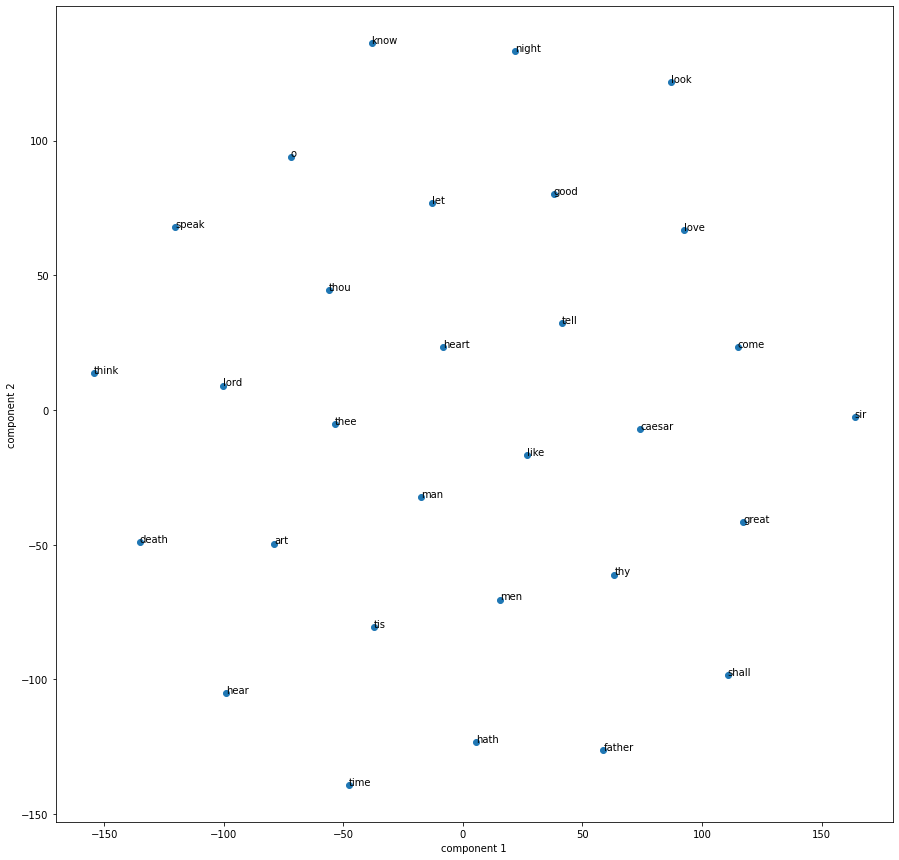

In [95]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(comedy_counts_words[np.array(comedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = comedy_selected_words)

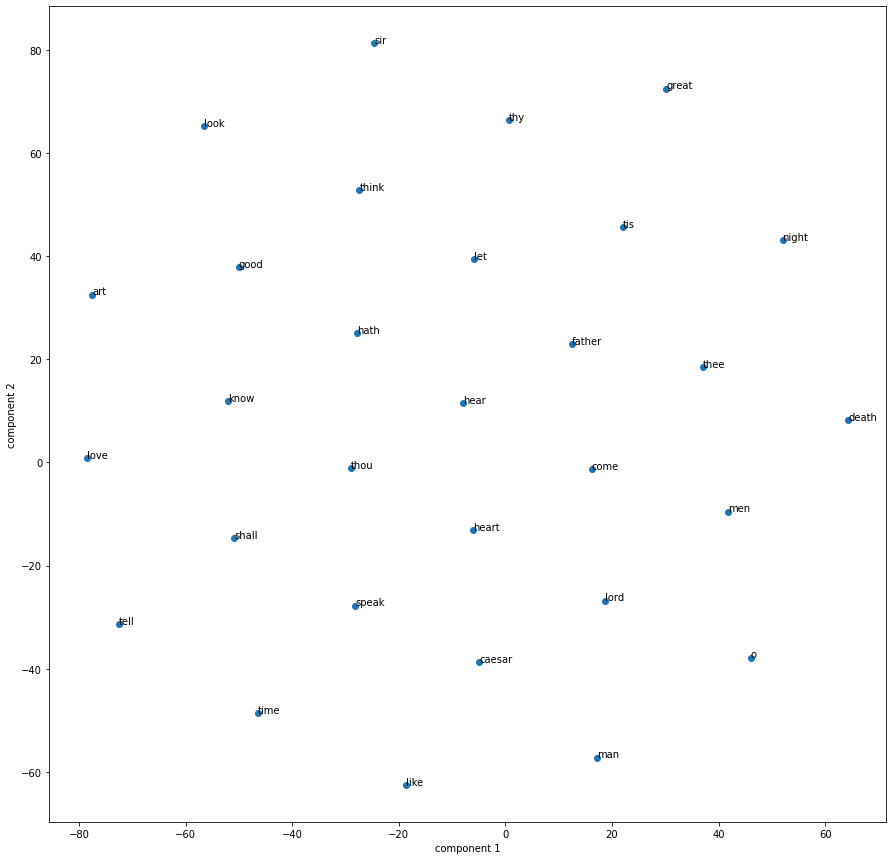

In [96]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(tragedy_counts_words[np.array(tragedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = tragedy_selected_words)

2.7.2 **t-SNE** for each vector representation based on **TF-IDF**

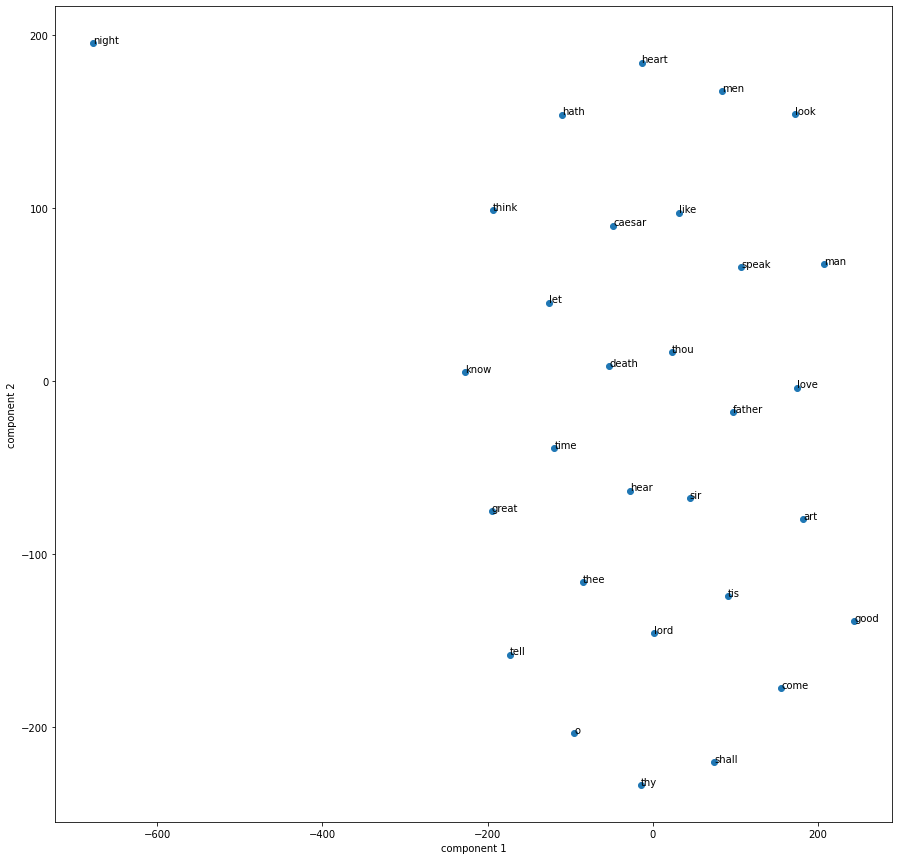

In [97]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(comedy_tfidf_words[np.array(comedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = comedy_selected_words)

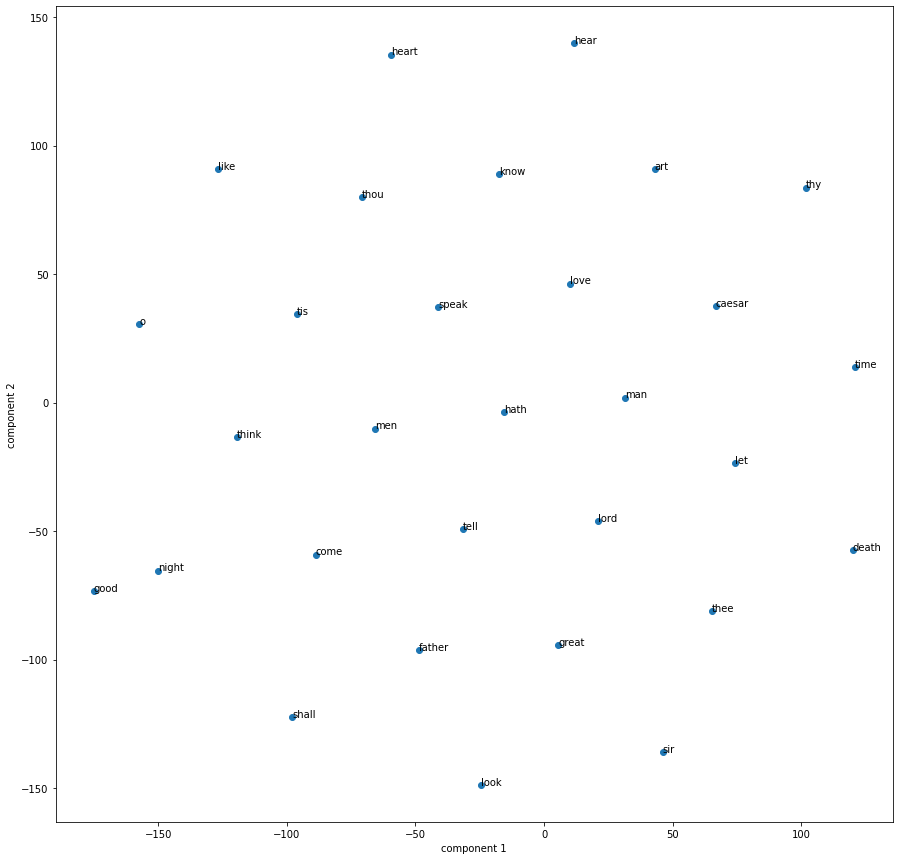

In [98]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(tragedy_tfidf_words[np.array(tragedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = tragedy_selected_words)

2.7.3 **t-SNE** for each vector representation based on **LDA**

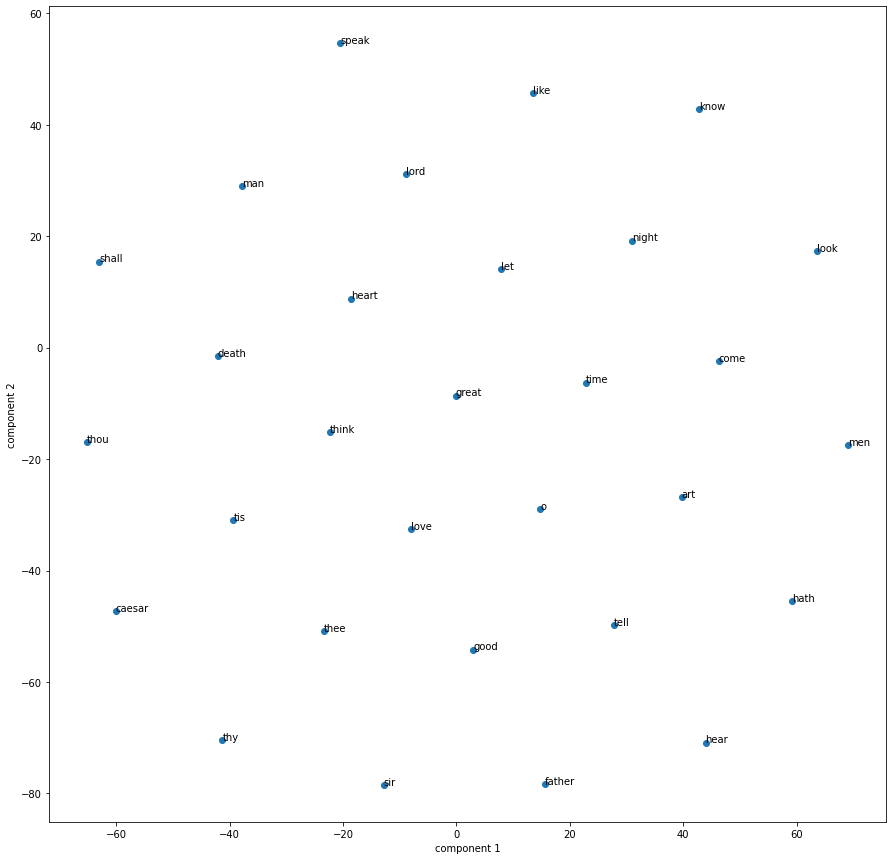

In [102]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(comedy_LDA_words[np.array(comedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = comedy_selected_words)

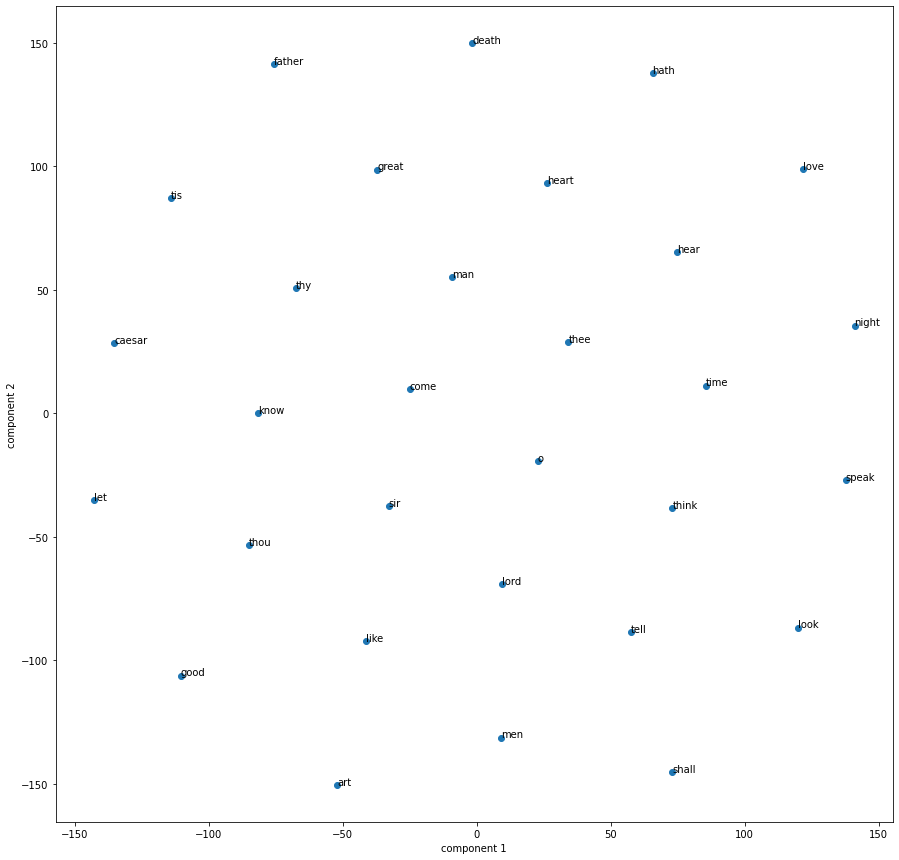

In [103]:
tsne = TSNE(n_components=2) # project to 2 dimensions
projected = tsne.fit_transform(tragedy_LDA_words[np.array(tragedy_selected_words_index)])

spatial_relationship (projected_vecs = projected, selected_words = tragedy_selected_words)

**Comments:** I used t-SNE to reduce the dimensionality and to cluster some word vectors obtained from several different vectorization techniques. However, the spatial distances of these words actually do not make much sense, because some words having similar meanings are shown to have larger distances than other words having quite different meanings .

---



## 2.8 Fit an SVM model

In [104]:
# Merge all of the comedy and tragedy plays
Comedy_and_Tragedy_Plays = np.array(Comedy_Plays_txt+Tragedy_Plays_txt)

# Construct binary indicator for comedy and tragedy plays
is_comedy = np.array([0]*len(Comedy_Plays_txt)+[1]*len(Tragedy_Plays_txt))

# set the seed for numpy.random
np.random.seed(seed=1)
# We shuffle these messages to avoid the biased (that is, uneven) distribution of these texts when putting them into the training, validation and test datasets.
shuffled_idxs = np.random.choice(range(len(Comedy_and_Tragedy_Plays)), size=len(Comedy_and_Tragedy_Plays),replace=False)
Comedy_and_Tragedy_Plays = Comedy_and_Tragedy_Plays[shuffled_idxs]
is_comedy = is_comedy[shuffled_idxs]

# We randomly select 80% of the data for training and 20% of the data for testing
pct_train = 0.8
train_bool = np.random.random(len(Comedy_and_Tragedy_Plays))<=pct_train
plays_train = Comedy_and_Tragedy_Plays[train_bool]
plays_test = Comedy_and_Tragedy_Plays[~train_bool]
is_comedy_train = is_comedy[train_bool]
is_comedy_test = is_comedy[~train_bool]

# we also have a validation set to check the progress of the model during training
pct_val = 0.2
val_idxs = np.random.random(size=len(plays_train))<=pct_val
is_comedy_val = is_comedy_train[val_idxs]
is_comedy_val.shape
plays_val = plays_train[val_idxs]

# We reconfigure train so that it doesn't include validation
plays_train = plays_train[~val_idxs]
is_comedy_train = is_comedy_train[~val_idxs]
print('Train: {0} \nValidation: {1} \nTest: {2}'.format(len(plays_train), len(plays_val), len(plays_test)))
parsed_train = [single_clean_tokenization(str(d)) for d in plays_train]
parsed_val = [single_clean_tokenization(str(d)) for d in plays_val]
parsed_test = [single_clean_tokenization(str(d)) for d in plays_test]

Train: 49820 
Validation: 12268 
Test: 15508


In [112]:
def fitting_SVM_model_validation_accuracy (vec_tech):
    svc = LinearSVC(random_state=11)
    vec_tech_transform_train = vec_tech.transform(parsed_train)
    vec_tech_transform_val = vec_tech.transform(parsed_val)
    svc.fit(vec_tech_transform_train, is_comedy_train)
    accuracy = accuracy_score(is_comedy_val, svc.predict(vec_tech_transform_val))
    print(accuracy)

In [113]:
def fitting_SVM_model_test_accuracy (vec_tech):
    svc = LinearSVC(random_state=11)
    vec_tech_transform_train = vec_tech.transform(parsed_train)
    vec_tech_transform_test = vec_tech.transform(parsed_test)
    svc.fit(vec_tech_transform_train, is_comedy_train)
    accuracy = accuracy_score(is_comedy_test, svc.predict(vec_tech_transform_test))
    print(accuracy)

2.8.1 SVM model using yhe vectors based on **Word Counts**

2.8.1.1 Accuracy on the validation dataset

In [109]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# Only fitting with the training dataset
cv.fit(parsed_train)

fitting_SVM_model_validation_accuracy(cv)

0.6379197913270297


2.8.1.2 Accuracy on the test dataset

In [114]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# Only fitting with the training dataset
cv.fit(parsed_train)

fitting_SVM_model_test_accuracy(cv)

0.6321253546556616


2.8.2 SVM model using yhe vectors based on **TF-IDF**

2.8.2.1 Accuracy on the validation dataset

In [115]:
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# Only fitting with the training dataset
tfidf.fit(parsed_train)

fitting_SVM_model_validation_accuracy(tfidf)

0.6393870231496577


2.8.2.2 Accuracy on the test dataset

In [116]:
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# Only fitting with the training dataset
tfidf.fit(parsed_train)

fitting_SVM_model_test_accuracy(tfidf)

0.6319319061129739


2.8.2.3 Accuracy on the test dataset

In [118]:
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# get vectors
tfidf_train_vecs = tfidf.fit_transform(parsed_train)

n_components = 10
nmf = NMF(n_components=n_components)
nmf.fit_transform(tfidf_train_vecs)
svc = LinearSVC(random_state=12)
svc.fit(nmf.transform(tfidf.fit_transform(parsed_train)), is_comedy_train)
base_accuracy = accuracy_score(is_comedy_test, svc.predict(nmf.transform(tfidf.transform(parsed_test))))
base_accuracy

0.5102527727624452

2.8.3 SVM model using yhe vectors based on **LDA**

2.8.3.1 Accuracy on the validation dataset

In [119]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# get vectors
cv_train_vecs = cv.fit_transform(parsed_train)

LDA = LatentDirichletAllocation(n_components=10)
LDA.fit_transform(cv_train_vecs)
svc = LinearSVC(random_state=13)
svc.fit(LDA.transform(cv.fit_transform(parsed_train)), is_comedy_train)
base_accuracy = accuracy_score(is_comedy_val, svc.predict(LDA.transform(cv.transform(parsed_val))))
base_accuracy

0.5086403651776981

2.8.3.2 Accuracy on the test dataset

In [120]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
# get vectors
cv_train_vecs = cv.fit_transform(parsed_train)

LDA = LatentDirichletAllocation(n_components=10)
LDA.fit_transform(cv_train_vecs)
svc = LinearSVC(random_state=13)
svc.fit(LDA.transform(cv.fit_transform(parsed_train)), is_comedy_train)
base_accuracy = accuracy_score(is_comedy_test, svc.predict(LDA.transform(cv.transform(parsed_test))))
base_accuracy

0.5217307196285788

## 2.9 Using SpaCy’s implementation of GloVe embeddings
### 2.9.1 Construct a **pipeline** for the GloVe-based features in the SVM model

In [121]:
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

     |████████████████████████████████| 96.4MB 4.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=023d13d60ddf848ce983f58c07952c5a348b937abfdf52884ca00a4e76a56ef9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_gn0j5q/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [122]:
# Creat a list of all words we are interested in 
words_list =  Comedy_Plays_txt + Tragedy_Plays_txt

# create word-level representations
glove_words = [nlp(w).vector for w in words_list]

# Notice that there are 7026 word vectors and each vector is 300-dimensional dense representation
print(len(glove_words), glove_words[0].shape[0])

77596 300


In [123]:
class GloveVectorizer():
    def __init__(self):
        self.nlp = en_core_web_md.load()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.concatenate([self.nlp(doc).vector.reshape(1, -1) for doc in X])
Glove = GloveVectorizer()
svm = LinearSVC()
pipeline = make_pipeline(Glove, svm)

### 2.9.2 Accuracy on **validation dataset** using GloVe-based features in the SVM model 

In [125]:
# Fit SVM model on training dataset using GloVe-based features
pipeline.fit(plays_train.tolist(), is_comedy_train.tolist())
# Prediction on validation dataset with SVM model using GloVe-based features
y_pred = pipeline.predict(plays_val.tolist())

In [126]:
# Compute the accuracy of SVM model on validation dataset using GloVe-based features
base_accuracy = accuracy_score(is_comedy_val.tolist(), y_pred)
base_accuracy

0.6082491033583306

### 2.9.3 Accuracy on **test dataset** using GloVe-based features in the SVM model 

In [128]:
# Fit SVM model on training dataset using GloVe-based features
pipeline.fit(plays_train.tolist(), is_comedy_train.tolist())
# Prediction on test dataset with SVM model using GloVe-based features
y_pred = pipeline.predict(plays_test.tolist())

In [130]:
# Compute the accuracy of SVM model on test dataset using GloVe-based features
base_accuracy = accuracy_score(is_comedy_test.tolist(), y_pred)
base_accuracy

0.5973046169718855

**Comments:** The prediction accuracies using GloVe-based features on both validation dataset and test dataset are close to the prediction accuracies using words count and TF-IDF, and are higher than the prediction accuracies using NMF and LDA. This result shows that the GloVe-based features contain more information of words and can provide (relatively) better predictions. 

# 3) Exploring using Machine Learning Methods

## 3.1) Constructing Support Functions for ML Analyses

**Note:** As we can see from the analyses in Section 2, the plays in different categories share some high-frequence tokens. Therefore, we bluid a custom list of stopwords in one of the following function. 

<span style="color:blue">
    Class to drop features from the dataset.
</span>

In [133]:
class FeatureFilter(TransformerMixin, BaseEstimator):
    def __init__(self, features, debug=False):
        self.features = features
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(self.features, axis=1)
        
        if self.debug:
            print("Remaining features: ", X.columns)
        
        return X

<span style="color:blue">
    Class to split the feature `ActSceneLine` into 3 separate features. This will help to concat the lines at different levels: Act or Scene.
</span>

In [134]:
class FeatureSplitter(TransformerMixin, BaseEstimator):
    def __init__(self, feature, debug=False):
        self.feature = feature
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        spit_s = X[self.feature].str.split('.')
        split_df = spit_s.apply(pd.Series)
        split_df.columns = ['Act', 'Scene', 'Line']
        
        X = X.drop(self.feature, axis=1)
        X = X.join(split_df)
        
        return X

<span style="color:blue">
    Class that calculates the average length for all the sentences of each observation in the dataset. Each observation in the dataset can be a concatenation by Play or by Act, so the class will calculate the average length of the sentences at the given level.
</span>

In [135]:
# Here I perform Lemmatization, convert words to lower case and remove non-alphabetic words and stopwords
def clean_tokenization (doc, tokenization_model = nlp):
    lemma_doc =  [token.lemma_.lower() for token in tokenization_model(doc)] # Perform Lemmatization and convert words to lower case
    alphabetic_lemma_doc = [lemma_token for lemma_token in lemma_doc if lemma_token.isalpha() or lemma_token == '-PRON-'] # Remove non-alphabetic words
    NoStopWord_alphabetic_lemma_doc = [alphabetic_lemma_token for alphabetic_lemma_token in alphabetic_lemma_doc if alphabetic_lemma_token not in stopwords] # Remove stopwords
    clean_tokenization = NoStopWord_alphabetic_lemma_doc 
    return clean_tokenization

In [136]:
class SentenceAverageLengthCalculator(TransformerMixin, BaseEstimator):
    def __init__(self):
        return
    
    def get_player_avg_sentence_length(self, lines_df):

        player_lines = [player_line.lower() for player_line in lines_df.PlayerLine]
        player_avg_sentences_length = list()
        for line in player_lines:
            sentences = nltk.sent_tokenize(line)
            filtered_sentences = [' '.join(clean_tokenization (sentence, tokenization_model = nlp)) for sentence in sentences]
            total_avg = sum( map(len, filtered_sentences) ) / len(filtered_sentences)
            player_avg_sentences_length.append(total_avg)

        lines_df['AvgSentLength'] = player_avg_sentences_length
        return lines_df
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = self.get_player_avg_sentence_length(X) 
        return X

<span style="color:blue">
    Class that computes the sentiment analysis for all the sentences of each observation in the dataset. Each observation in the dataset can be an concatenation by Play or by Act, so the class will compute the sentiment of the sentences at the given level.
</span>

In [137]:
class SentimentCalculator(TransformerMixin, BaseEstimator):
    def __init__(self):
        return
    
    def get_player_sentiment(self, lines_df):
        Senti = SentimentIntensityAnalyzer()

        player_line = lines_df.PlayerLine
        sentiment_list = list()
        for sentence in player_line:
            ss = Senti.polarity_scores(sentence)
            ss['NegativeSentiment'] = ss.pop('neg')
            ss['NeutralSentiment'] = ss.pop('neu')
            ss['PositiveSentiment'] = ss.pop('pos')
            ss.pop('compound')
            sentiment_list.append(ss)

        lines_df = lines_df.join(pd.DataFrame(sentiment_list))
        return lines_df
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = self.get_player_sentiment(X) 
        return X

<span style="color:blue">
    This function aggregates the Lines of the dataset at the given level, grouping the observations according a criteria and doing a concatenation of the PlayerLine.
</span>

In [138]:
class FeatureAggregator(TransformerMixin, BaseEstimator):
    def __init__(self, feature_aggregation, feature_to_aggregate, debug=False):
        self.feature_aggregation = feature_aggregation
        self.feature_to_aggregate = feature_to_aggregate
        self.debug = debug
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        gb_X = X.groupby(self.feature_aggregation, as_index=False)
        
        aggr_X = gb_X[self.feature_to_aggregate].apply(lambda x: ' '.join(x))
        
        aggr_df = pd.DataFrame(aggr_X)
        
        values_df = pd.DataFrame(aggr_df.values, columns=[self.feature_to_aggregate])
        index_list = aggr_df.index.tolist()

        X = pd.DataFrame(index_list, columns=self.feature_aggregation)
        X = X.join(values_df)
        
        #X = get_player_avg_sentence_length(X)
        #get_player_sentiment(X)
        
        return X

<span style="color:blue">
    The below function implements a `Pipeline` to prepare the dataset for the analysis. Below are the steps that the pipeline executes:<br>
    1) Removing the features that are not useful for the analysis.<br>
    2) Splitting into 3 separate columns the feature `ActSceneLine`.<br>
    3) Grouping the observation according to a criteria (for example, by `Act`) and then concatenating all the lines corresponding to each Act. <br>
    4) Calculating the `average length` of all the lines already aggregated in one observation, and creating a new feature for further analysis.<br>
    5) Calculating the `sentiment` of all the lines aggregated in one observation, and creating 3 new features with the negative, neutral and positive score.
</span>

In [139]:
def feature_transformation(raw_df, feature_aggregation, debug=False):
    
    features_to_remove = 'PlayerLinenumber'
    feature_to_split = 'ActSceneLine'
    feature_to_aggregate = 'PlayerLine'

    plays_pipeline = Pipeline([
        ('feature_filter', FeatureFilter(features_to_remove, debug)),
        ('feature_splitter', FeatureSplitter(feature_to_split, debug)),
        ('feature_aggregator', FeatureAggregator(feature_aggregation, feature_to_aggregate, debug)),
        ('sentence_avg_length_calculator', SentenceAverageLengthCalculator()),
        ('sentiment_calculator', SentimentCalculator()),
    ])

    filtered_df = plays_pipeline.fit_transform(raw_df, None)
    
    return filtered_df

<span style="color:blue">
    Below there are functions to process the Play Lines:<br><br>
    -`num_and_short_word_preprocessor` removes numbers, 1-letter and 2-letter words.<br>
    -`create_stop_words` uses the stop words from nltk.<br>
    -`custom_tokenizer` breaks down the corpora into words and removes the plural of words.<br>
    -`preprocess_corpora` and `get_player_lines` are just a pipeline of the above functions.
</span>

In [140]:
# Function to remove numbers and small words (1 or 2 letters) from a document
def num_and_short_word_preprocessor(tokens):
    # Regular expression for numbers
    no_numbers = re.sub('(\d)+', '', tokens.lower())
    
    # Regular expression for 1-letter and 2-letter words
    no_short_words = re.sub(r'\b\w{1,2}\b', '', no_numbers)
    
    return no_short_words

# Function to return a list of stop words to consider
def create_stop_words():
    # We create a set of stop word
    stops = stopwords 

    # We define individual numbers and letters as stop words
    all_letters_numbers = string.digits + string.ascii_letters

    stops = stops.union(['abstract', 'using', 'based', 'via', 'data', 'log', 'upper', 'lower',
                        'mit', 'press', 'shown', 'figure', 'set', 'information', 'processing',
                        'step', 'basis', 'error', 'rate', 'ha', 'two', 'one', 'also', 'given',
                        'example', 'number', 'used', 'wa', 'weight', 'point', 'case', 'result',
                        'show', 'value', 'input', 'output', 'different', 'first', 'use'])  # add some stopwords
    
    stops = stops.union(list(all_letters_numbers))
    
    return stops

# Function to convert plurals into singulars
def custom_tokenizer(doc):
    #stemmer = SnowballStemmer("english")
    
    #word_tokenizer = RegexpTokenizer(r'\w+')
    tokens = clean_tokenization (doc, tokenization_model = nlp)

    wnl = WordNetLemmatizer()
    singular_tokens = [wnl.lemmatize(i) for i in tokens]
     
    #stems = [stemmer.stem(t) for t in singular_tokens]

    #return stems
    return singular_tokens

def preprocess_corpora(corpora):
    
    stop_words = create_stop_words()

    no_num_short_word_corpora = [num_and_short_word_preprocessor(sentence) for sentence in corpora]
    
    stemmed_corpora = [custom_tokenizer(doc) for doc in no_num_short_word_corpora]

    processed_corpora = []
    for doc in stemmed_corpora:
        processed_corpora.append([word for word in doc if not word in stop_words])
    
    return processed_corpora

def get_player_lines(aggregated_lines_df):
    aggr_player_line = [player_line.lower() for player_line in aggregated_lines_df.PlayerLine]
    tokenized_player_lines = preprocess_corpora(aggr_player_line)
    
    return tokenized_player_lines

<span style="color:blue">
    The below 2 functions compute the `word2vec` vector for every observation in the dataset, at the aggregation level that is provided (normally Play or Act).
</span>

In [141]:
def sentence_vectorizer(sentence, model):
    sentence_vec =[]
    num_words = 0
    for word in sentence:
        try:
            if num_words == 0:
                sentence_vec = model[word]
            else:
                sentence_vec = np.add(sentence_vec, model[word])
            num_words +=1
        except:
            pass
     
    return np.asarray(sentence_vec) / num_words

def get_word2vec_model(lines_df, vector_size = 100):
    
    tokenized_lines = get_player_lines(lines_df)
    
    model = Word2Vec(tokenized_lines, size = vector_size, min_count=1) 
    model.train(tokenized_lines, total_examples=len(tokenized_lines), epochs=10)

    X = []
    for sentence in tokenized_lines:
        X.append(sentence_vectorizer(sentence, model))   
    
    return {'lines_df': lines_df, 'vec' : X, 'model': model} 

<span style="color:blue">
    The below function computes the `doc2vec` vector for every observation in the dataset, at the aggregation level that is provided (normally Play or Act).
</span>

In [142]:
def get_doc2vec_model(lines_df, vector_size = 100):
    
    tokenized_lines = get_player_lines(lines_df)
    
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_lines)]
    model = Doc2Vec(documents, size = vector_size, window=2, min_count=1, workers=4)
    
    Y = model.docvecs.vectors_docs
    
    return {'lines_df': lines_df, 'vec' : Y, 'model': model} 

<span style="color:blue">
    The below function computes the `TF-IDF` vector for every observation in the dataset, at the aggregation level that is provided (normally Play or Act).
</span>

In [143]:
def get_tf_idf_model(lines_df, ngram = 2, features = 100): 
    vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range = (ngram, ngram), 
                                 preprocessor = num_and_short_word_preprocessor, tokenizer=custom_tokenizer,
                                max_features=features)

    tfidf_matrix = vectorizer.fit_transform(lines_df.PlayerLine)
    tfidf_matrix = tfidf_matrix.toarray()

    return {'lines_df': lines_df, 'vec' : tfidf_matrix, 'model': vectorizer}

<span style="color:blue">
    The below function adds to the dataset a new column with the computed cluster using the hierarchical method.
</span>

In [144]:
def get_hierarchical_clusters(model_dict, linkage, k=2):
    lines_df = model_dict['lines_df']
    lines_df = lines_df.copy()
    
    cluster_labels = fcluster(linkage, k, criterion='maxclust', depth=5)
    lines_df['Cluster'] = cluster_labels
    
    return lines_df

<span style="color:blue">
    The below function uses the KMeans clustering method to come up with the cluster structure in `k` clusters. Once calculated, it adds a new feature to the dataset.
</span>

In [145]:
def get_kmeans_clusters(model, k = 4, scale=False):
    lines_df = model['lines_df']
    vec = model['vec']
    if scale:
        vec = preprocessing.scale(vec)
    
    km = KMeans(n_clusters = k, random_state=99)
    km.fit(vec)

    clusters = km.labels_.tolist()
    lines_df['Cluster'] = clusters
    
    return lines_df   

<span style="color:blue">
    The below function calculate the Agglomerative Hierarchical Clustering and plots its results in a dendrogram chart.
</span>

In [146]:
def plot_hierarchical_clusters(model_dict, labels_key, title="", scale=False):
    
    lines_vec = model_dict['vec']
    if scale:
        lines_vec = preprocessing.scale(lines_vec)
        
    labels = model_dict['lines_df'][labels_key].values
    
    dist = 1 - cosine_similarity(lines_vec)
    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(12, 12)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels=labels);
    
    #plt.tick_params(\
    #    axis= 'x',          # changes apply to the x-axis
    #    which='both',      # both major and minor ticks are affected
    #    bottom='off',      # ticks along the bottom edge are off
    #    top='off',         # ticks along the top edge are off
    #    labelbottom='off')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout() #show plot with tight layout
    plt.title(title, fontsize = 25)
    
    return linkage_matrix

    #uncomment below to save figure
    #plt.savefig('ward_clusters_2.png', dpi=200) #save figure as ward_clusters

## 3.2) Analysis by Play

### 3.2.1) Analysis using the vectorized transformation of PlayerLine

<span style="color:blue">
    The analysis by `Play` should give us a first intuition about the existence of clusters in Shakespeare's plays. To do that, we are concatenating all the lines in a play and extracting the features from each pay using the following methods:<br>
    -Word2Vec<br>
    -Doc2Vec<br>
    -TF-IDF<br>
    Finally, we are using hierarchical clustering to see how the plays are related.
</span>

In [151]:
feature_aggregation = ['Play', 'PlayYear', 'PlayCategory']
lines_per_play_df = feature_transformation(plays_raw_df, feature_aggregation, debug=False) 
lines_per_play_df

,Play,PlayYear,PlayCategory,PlayerLine,AvgSentLength,NegativeSentiment,NeutralSentiment,PositiveSentiment
0,A Comedy of Errors,1594,Comedy,"Proceed, Solinus, to procure my fall And by th...",36.921509,0.128,0.747,0.125
1,A Midsummer nights dream,1595,Comedy,"Now, fair Hippolyta, our nuptial hour Draws on...",41.274241,0.119,0.698,0.183
2,A Winters Tale,1609,Comedy,"If you shall chance, Camillo, to visit Bohemia...",41.649425,0.111,0.728,0.161
3,Alls well that ends well,1602,Comedy,"In delivering my son from me, I bury a second ...",39.599708,0.103,0.702,0.195
4,Antony and Cleopatra,1608,Tragedy,"Nay, but this dotage of our general's O'erflow...",33.224917,0.114,0.714,0.172
5,As you like it,1599,Comedy,"As I remember, Adam, it was upon this fashion ...",38.116717,0.110,0.694,0.196
6,Coriolanus,1608,Tragedy,"Before we proceed any further, hear me speak. ...",35.203220,0.120,0.724,0.157
7,Cymbeline,1609,Tragedy,You do not meet a man but frowns: our bloods N...,38.483890,0.126,0.708,0.166
8,Hamlet,1600,Tragedy,"Who's there? Nay, answer me: stand, and unfold...",37.685365,0.117,0.722,0.161
9,Henry IV,1597,History,"So shaken as we are, so wan with care, Find we...",42.260606,0.119,0.732,0.149


### 3.2.2) Word2Vec & Hierachical clustering

<span style="color:blue">
    The hierarchical clustering applied to the Word2Vec method returns 2 main clusters, so clearly there is a difference among the groups of plays. Let's see what happens with other methods.
</span>

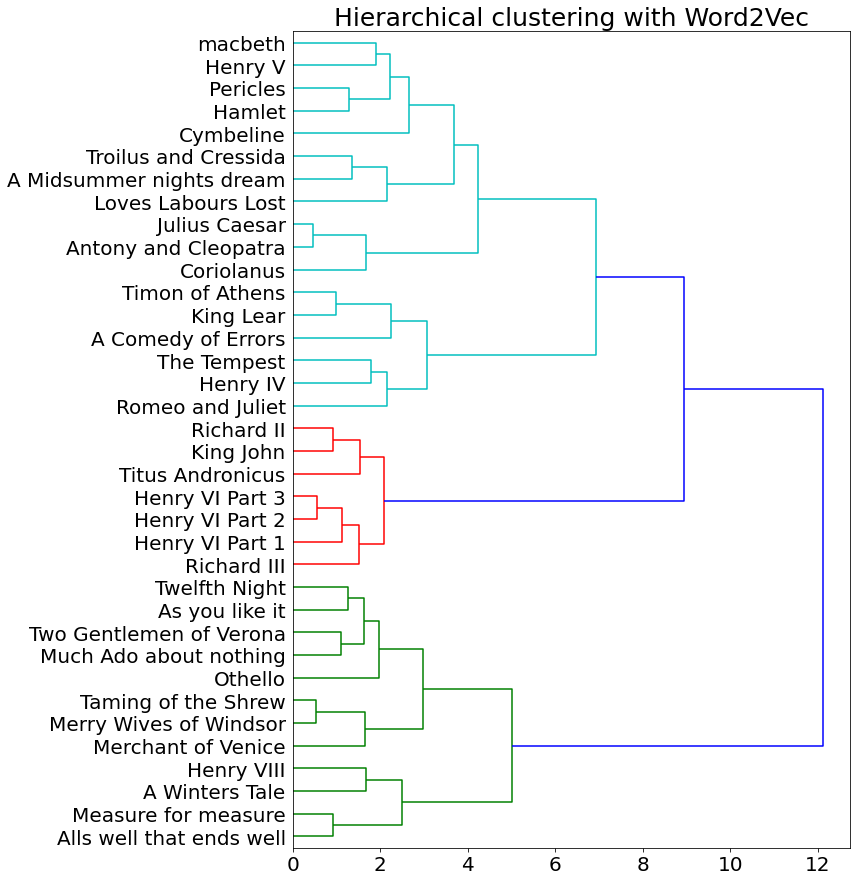

In [152]:
word2vec_dict = get_word2vec_model(lines_per_play_df, vector_size = 250)
 
linkage_word2vec_play = plot_hierarchical_clusters(word2vec_dict, 'Play', 
                                                   title='Hierarchical clustering with Word2Vec', 
                                                   scale=True)

**Comments:** It is interesting to see that several comedy-tragedy pairs are grouped together as the closet plays in their writting styles. For example, Pericles (comedy) and Hamlet (tragedy), A Midsummer nights dream (comedy) and Troilus and Cressida (tragedy), and so on. Two big clusters appear on above dendrogram; each of them includes several tragedy and comedy. This implies that the comedy/tragedy category probably does not influence much on our analyses of the styles of plays for determing if the plays are written by one person or a group of people. 

### 3.2.3) Doc2Vec & Hierachical clustering

<span style="color:blue">
    The same clustering method is applied to Doc2Vec, and we obtain 3 main clusters considering only the plays. This confirms that there is room to continue digging into the structure of the plays.
</span>

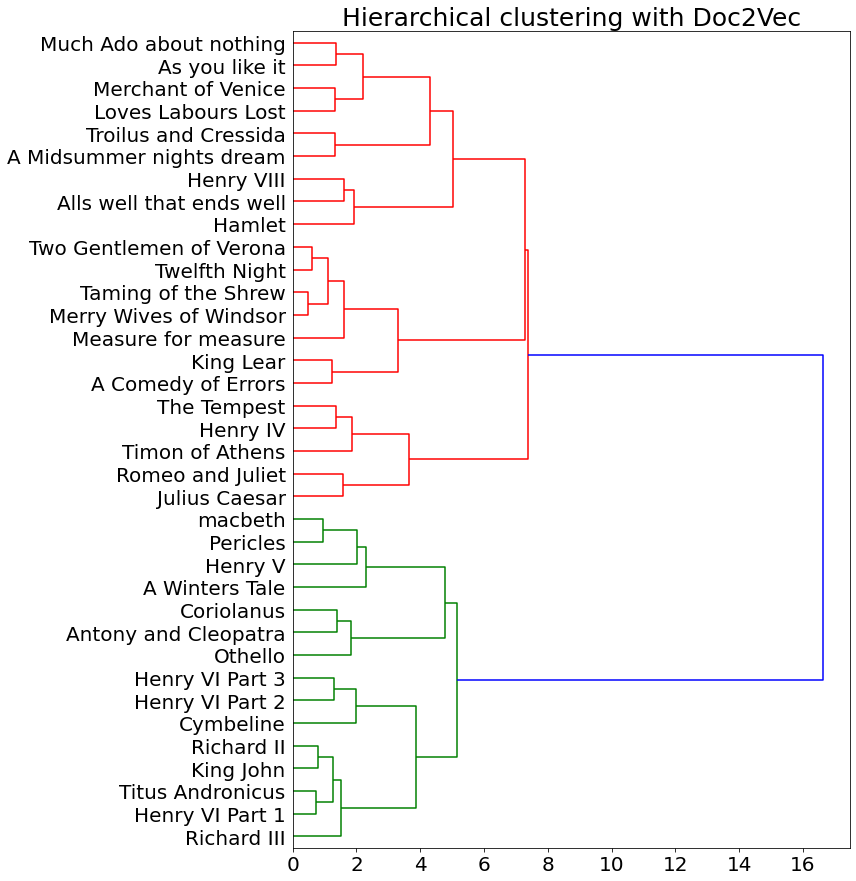

In [153]:
doc2vect_dict = get_doc2vec_model(lines_per_play_df, vector_size = 1000)

linkage_doc2vec_play = plot_hierarchical_clusters(doc2vect_dict, 'Play', title='Hierarchical clustering with Doc2Vec', 
                                                  scale=True)

**Comments:** Again, several comedy-tragedy pairs are grouped together as the closet plays in their writting styles. For example, Pericles (comedy) and Hamlet (tragedy), A Midsummer nights dream (comedy) and Troilus and Cressida (tragedy), and so on. Two big clusters appear on above dendrogram; each of them includes several tragedy and comedy. 

### 3.2.4) TF-IDF & Hierachical clustering

<span style="color:blue">
    Last, we also apply a TD-IDF transformation of the lines contained in a play, there is a more complex cluster structure, but if we keep only two clusters, that points at the same direction as the other transformation methods as we are going to see in the next point.
</span>

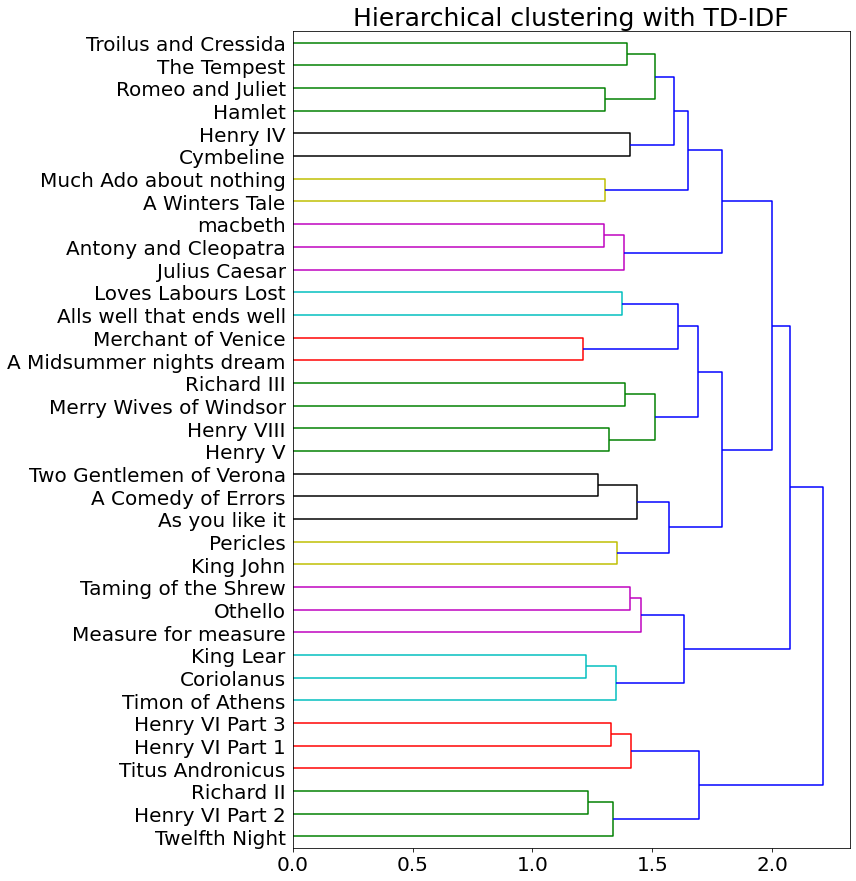

In [154]:
td_idf_dict = get_tf_idf_model(lines_per_play_df, ngram=3, features=250)
_ = plot_hierarchical_clusters(td_idf_dict, 'Play', title='Hierarchical clustering with TD-IDF', scale=True)

## 3.2.5) Analysis using other numerical features

<span style="color:blue">
    Here we are going to try to find cluster structure using other numerical features in the dataset, such as `PlayYear`, `AvgSentLength`, `NegativeSentiment`, `NeutralSentiment`, `PositiveSentiment`. In this first approach, we are going to do it at Play level, that is, considering all the lines included in a given Play.<br><br>
    As we can see, there are 3 main clusters.
</span>

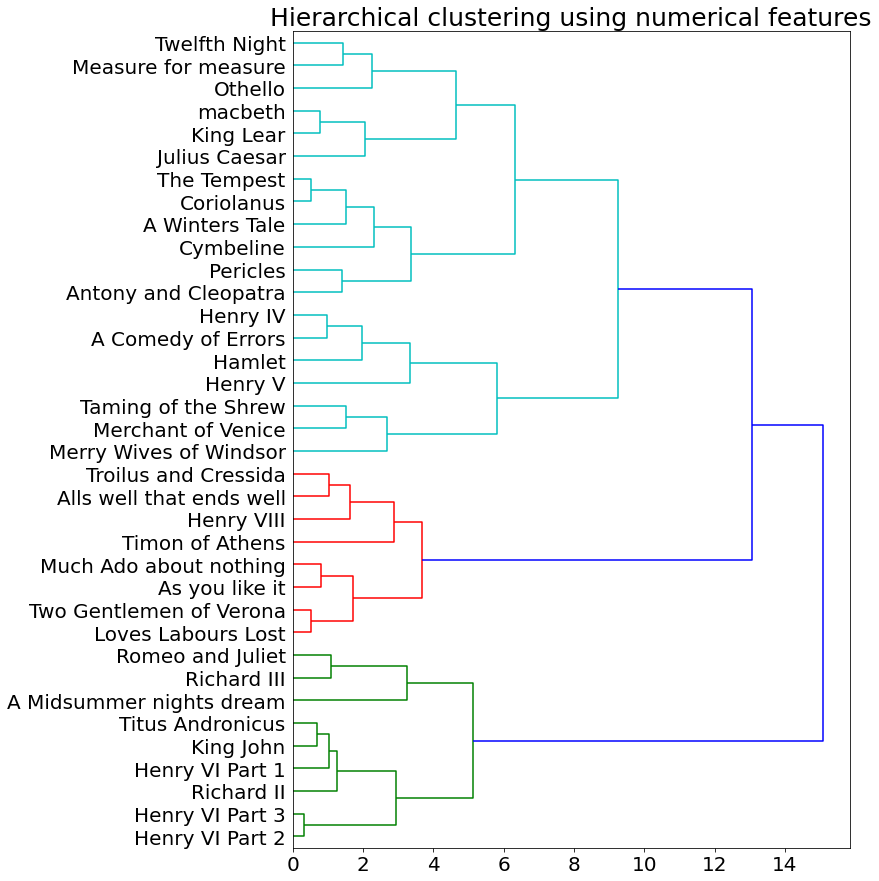

In [155]:
numerical_features = ['PlayYear', 'AvgSentLength', 'NegativeSentiment', 'NeutralSentiment', 'PositiveSentiment']
vec = lines_per_play_df[numerical_features]

num_dict = {'lines_df': lines_per_play_df, 'vec' : vec.values, 'model': None}

_ = plot_hierarchical_clusters(num_dict, 'Play', title='Hierarchical clustering using numerical features', scale=True)

## 3.2.6) Initial conclusions

<span style="color:blue">
    Even though the structure of the clusters may be quite different (comparing the cluster by the eye the partitions can be very different), the first analysis aggregating the lines per `Play` says that there are few clusters, but well separated.
</span>

## 3.3) Analysis per Act

### 3.3.1) Analysis using the vectorized transformation of PlayerLine

<span style="color:blue">
    The analysis per Act is going to be used in more detail shortly. In this section, we only are repeating the hierarchical clustering to see if there are different clusters when considering the Act as the unit to concatenate the lines of a play. Let's see...
</span>

In [156]:
act_feature_aggregation = ['Play', 'PlayYear', 'PlayCategory', 'Act']

lines_per_act_df = feature_transformation(plays_raw_df, act_feature_aggregation, debug=False)
lines_per_act_df.head(50)

,Play,PlayYear,PlayCategory,Act,PlayerLine,AvgSentLength,NegativeSentiment,NeutralSentiment,PositiveSentiment
0,A Comedy of Errors,1594,Comedy,1,"Proceed, Solinus, to procure my fall And by th...",63.674699,0.117,0.757,0.125
1,A Comedy of Errors,1594,Comedy,2,"Neither my husband nor the slave return'd, Tha...",32.727273,0.126,0.754,0.120
2,A Comedy of Errors,1594,Comedy,3,"ANTIPHOLUS Good Signior Angelo, you must excus...",34.329897,0.099,0.755,0.146
3,A Comedy of Errors,1594,Comedy,4,"You know since Pentecost the sum is due, And s...",31.556338,0.156,0.743,0.101
4,A Comedy of Errors,1594,Comedy,5,"I am sorry, sir, that I have hinder'd you, But...",40.156398,0.133,0.749,0.117
5,A Midsummer nights dream,1595,Comedy,1,"Now, fair Hippolyta, our nuptial hour Draws on...",47.782895,0.080,0.695,0.225
6,A Midsummer nights dream,1595,Comedy,2,"How now, spirit! whither wander you? Over hill...",49.505747,0.108,0.741,0.152
7,A Midsummer nights dream,1595,Comedy,3,"Are we all met? Pat, pat, and here's a marvell...",36.432203,0.135,0.704,0.160
8,A Midsummer nights dream,1595,Comedy,4,"lying asleep. Enter TITANIA and BOTTOM, PEASEB...",40.060150,0.092,0.732,0.176
9,A Midsummer nights dream,1595,Comedy,5,"'Tis strange my Theseus, that these lovers spe...",38.649038,0.135,0.658,0.207


### 3.3.2) Word2Vec & Hierachical clustering

<span style="color:blue">
    When doing Agglomerative Hierarchical Clustering considering the `Act` as the grouping unit and Word2Vec as the transformation method, a very well defined and balanced clusters are identified. 
</span>

**Notes:** Here we focus more on how many big clusters will be bifurcated from the root of the dendrogram rather than whether comedy and tragedy plays will be grouped together. Because the latter question has been investigated in previous parts.

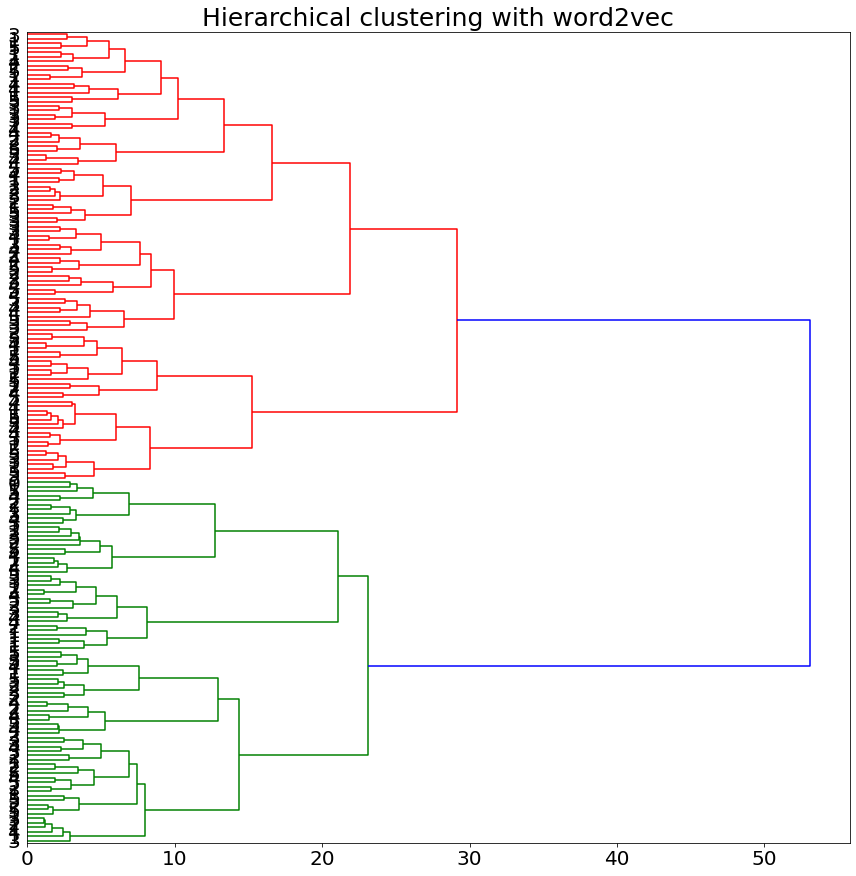

In [157]:
word2vect_act_dict = get_word2vec_model(lines_per_act_df, vector_size=250)
linkage_word2vec_act = plot_hierarchical_clusters(word2vect_act_dict, 'Act', 
                                                  title='Hierarchical clustering with word2vec', scale=True)

### 3.3.3) Doc2Vec & Hierachical clustering

<span style="color:blue">
    Very similar balance we obtain when doing Agglomerative Hierarchical Clustering considering using Word2Vec as the transformation method. 2 clusters well balanced.
</span>

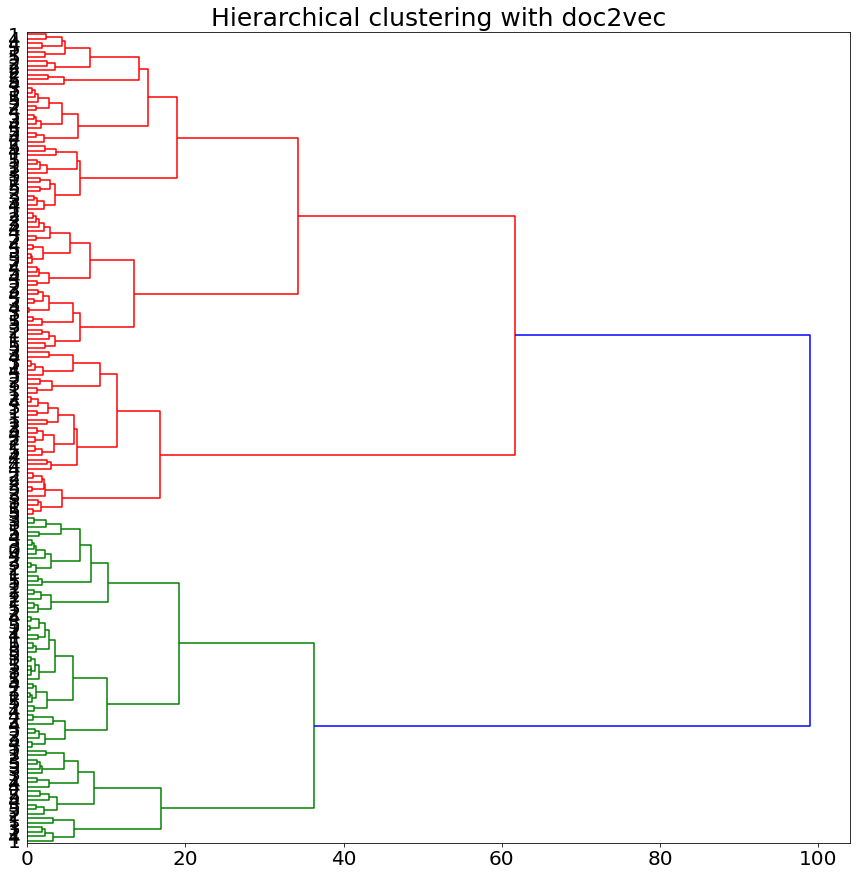

In [158]:
doc2vect_act_dict = get_doc2vec_model(lines_per_act_df, vector_size=250)
linkage_doc2vec_act = plot_hierarchical_clusters(doc2vect_act_dict, 'Act', 
                                                  title='Hierarchical clustering with doc2vec', scale=True)

### 3.3.4) TF-IDF & Hierachical clustering

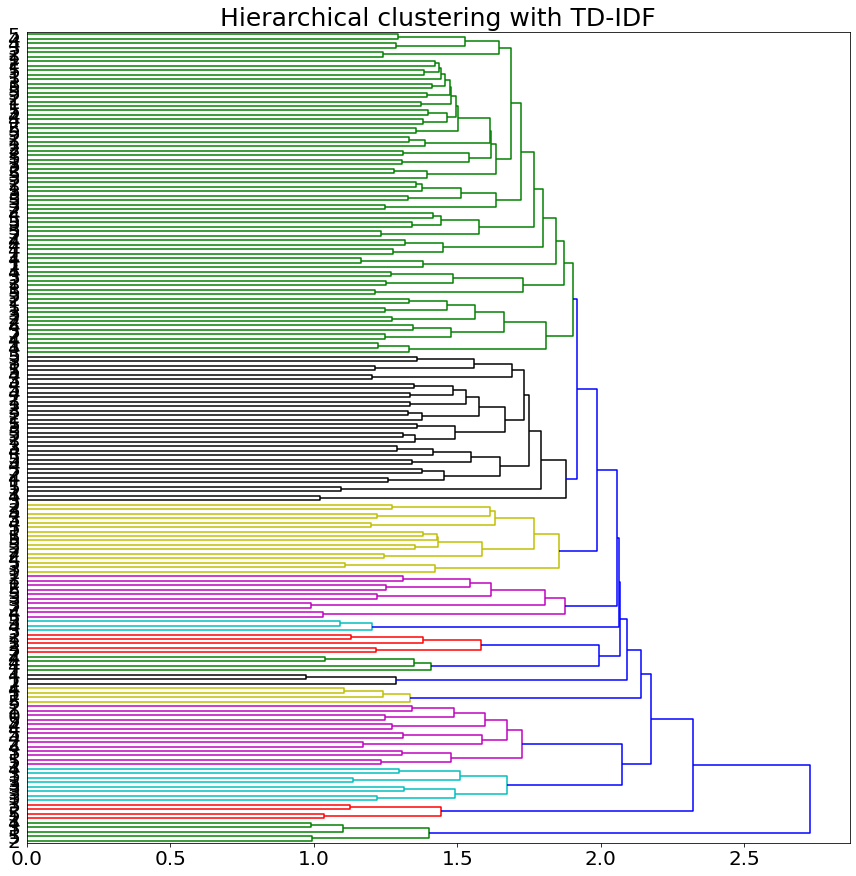

In [159]:
td_idf_act_dict = get_tf_idf_model(lines_per_act_df, ngram=3, features=1000)
_ = plot_hierarchical_clusters(td_idf_act_dict, 'Act', title='Hierarchical clustering with TD-IDF')

<span style="color:blue">
    Both Word2Vec and Doc2Vec return the same number of clusters as the analysis per Play. TF-IDF returns some more clusters, but we can make out that 5/6 clusters might be a good structure to research.<br>
    Analysis per Scene does not seem to be very useful, as it is quite likely that local structures distort the results and could be misleading.
</span>

## 3.3.5) Analysis using other numerical features

<span style="color:blue">
    Again, we are searching for cluster structure using `PlayYear`, `AvgSentLength`, `NegativeSentiment`, `NeutralSentiment`, `PositiveSentiment` previously calculated. <br>
    At Act level, that is, concatenating all lines included in an Act, we can make out 3 clusters very well defined.
</span>

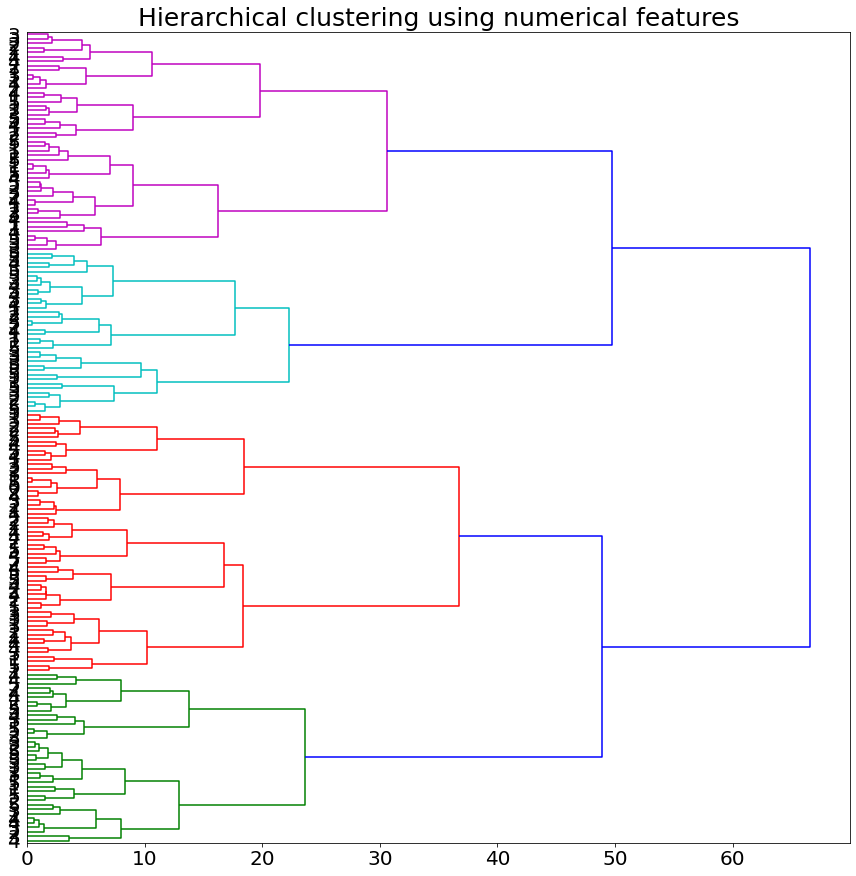

In [160]:
#lines_per_play_df
numerical_features = ['PlayYear', 'AvgSentLength', 'NegativeSentiment', 'NeutralSentiment', 'PositiveSentiment']
vec_act = lines_per_act_df[numerical_features]

num_act_dict = {'lines_df': lines_per_act_df, 'vec' : vec_act.values, 'model': None}

_ = plot_hierarchical_clusters(num_act_dict, 'Act', title='Hierarchical clustering using numerical features', scale=True)

## 3.3.6) More conclusions

<span style="color:blue">
    Aggregating at `Act` level we continue finding balanced clusters, that is, there are features that clearly distinguish Plays or Acts from the others, and the reason can be that they were written by different authors.
</span>

## 3.4) More detailed clustering per Act

<span style="color:blue">
    We are going to drill down in our analysis of Shakespeare's plays, by using other clustering methods over the plays, aggregated by `Act`. 
</span>

<span style="color:blue">
    The below function plots a pie chart showing the percentage of `Acts` that belong to each cluster, once a clustering method has been executed.
</span>

In [161]:
def cluster_pie_chart(lines_df, num_clusters, feature):
    # Pie chart
    labels = ['Cluster ' + str(i) for i in range(num_clusters)]
    sizes = [sum(lines_df['Cluster'] == i) for i in range(num_clusters)]
    colors = sns.color_palette("Set2")[:num_clusters]

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    fig1.subplots_adjust(wspace = 0.2, hspace = 0.3)
    patches, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, labeldistance=1,
                                        autopct='%1.1f%%', startangle=90)
    for text in texts:
        text.set_color('black')
    for autotext in autotexts:
        autotext.set_color('black')
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal') 
    plt.tight_layout()
    plt.title("Cluster distribution per " + feature)
    plt.show()

<span style="color:blue">
    The below function plots a pie chart of an individual `Play`, breaking down into its `Acts` and the cluster that they belong to, in order to visualize if there is a dominant cluster within the Play.
</span>

In [162]:
def play_pie_chart(play_df, play_title, ax1):
    # Pie chart
    num_acts = len(play_df.Act.unique())
    labels = ['Act ' + str(i+1) for i in range(num_acts)]
    sizes = [1] * num_acts
    clusters = play_df.Cluster.values

    
    colors = sns.color_palette("Set2")
    act_color = [colors[i] for i in clusters]

    #fig1, ax1 = plt.subplots()
    patches, texts = ax1.pie(sizes, colors = act_color, labels=labels, startangle=90, labeldistance=0.4)
    
    from matplotlib.lines import Line2D
    cmap = plt.cm.coolwarm
    
    custom_lines = list()
    unique_clusters = list(set(clusters))
    for cluster in unique_clusters:
        custom_lines.append(Line2D([0], [0], color=colors[cluster], lw=4))
    
    ax1.legend(custom_lines, unique_clusters, title="Clusters", loc="upper left", bbox_to_anchor=(-0.05, 1))
    ax1.set_title(play_title, fontsize=8)
    
    for text in texts:
        text.set_color('black')
    #for autotext in autotexts:
    #    autotext.set_color('black')
        
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    #plt.tight_layout()
    #plt.show()

<span style="color:blue">
    This function creates a small dashboard that shows the % of `Acts` that belong to each cluster plus how the clusters are distributed in each Play by Act.
</span>

In [163]:
def plot_cluster(play_df, num_clusters, feature):
    cluster_pie_chart(play_df, num_clusters, feature)
    
    # Create the subplots and set the size of the image
    figure_rows = math.ceil(len(play_df.Play.unique()) / 6)
    figure, ax_arr = plt.subplots(figure_rows, 6)
    figure.set_size_inches(20, figure_rows * 3)
    # Get a flat vector of plots, to help the access
    ax_vector = np.ravel(ax_arr)

    for i, play in enumerate(play_df.Play.unique()):
        current_ax = ax_vector[i]
        indiv_play_df = play_df.loc[play_df['Play'] == play]

        play_pie_chart(indiv_play_df, play, current_ax)
        #break
    

### 3.4.1) K-means with Word2Vec transformation (clustering per Act)

<span style="color:blue">
The below analysis corresponds with a K-Means with 3 clusters, that is the most consistent number of clusters obtained in previous steps. The method is executed using the word2vect transformation of the Plays, aggregated by Act, that is, every observation is a concatenation of all the lines included in an Act.<br><br>
In the analysis, we can see that there is kind of a dominant cluster, plus two smaller ones. If we analyze Play by Play, we can see that besides being mono-cluster Plays (something expected), there are Plays including 2 clusters, but rarely 3 clusters. This might be an indication that a Play is split in two authors, but normally not more. 
</span>

In [164]:
k=3

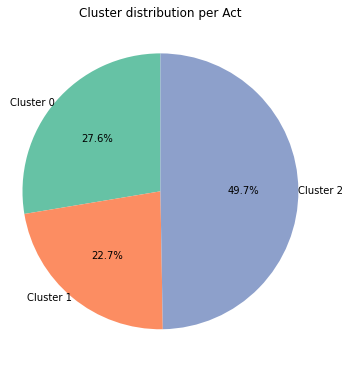

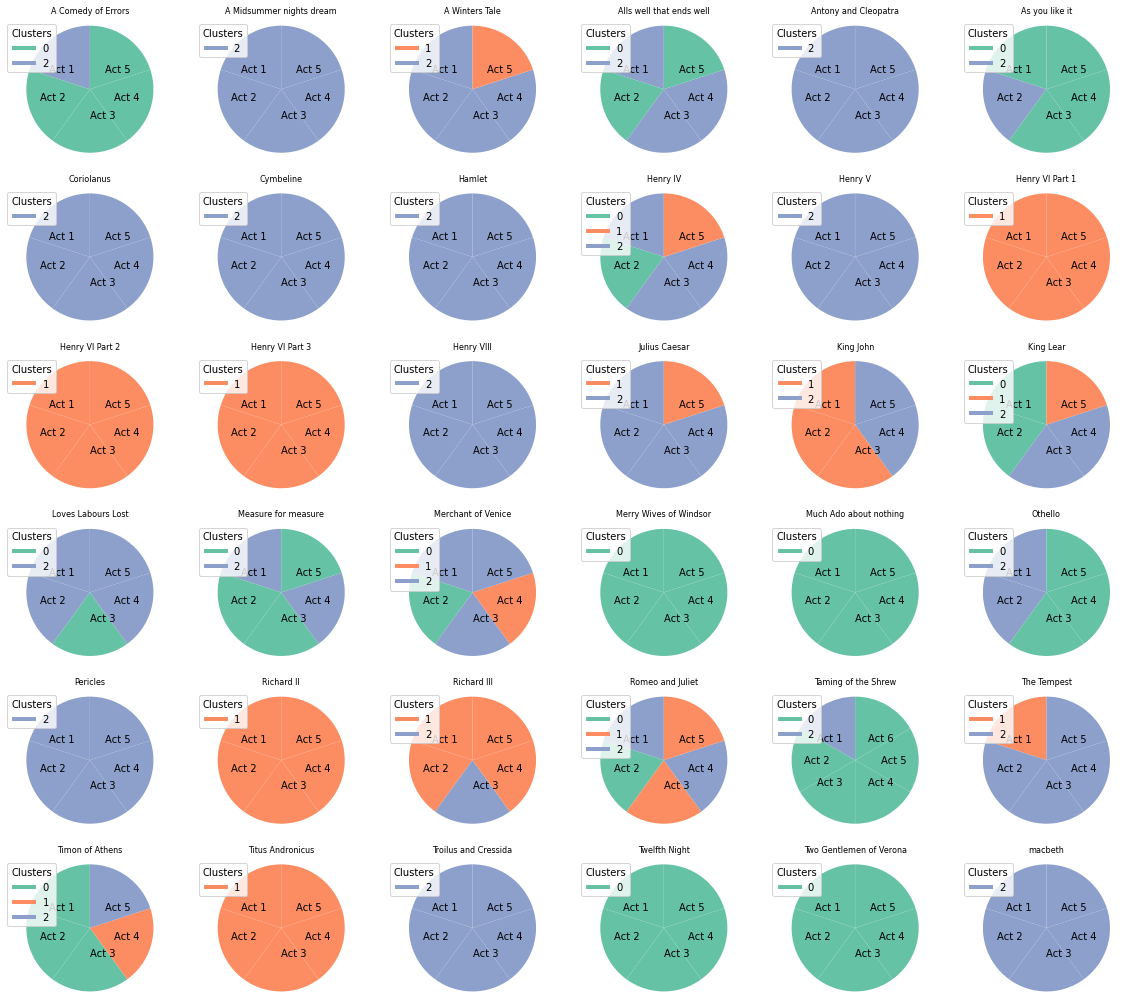

In [165]:
#kmeans_td_idf_clusters_df = get_kmeans_clusters(td_idf_act_dict, k=k, scale=True)
kmeans_td_idf_clusters_df = get_kmeans_clusters(word2vect_act_dict, k=k, scale=True)

plot_cluster(kmeans_td_idf_clusters_df, k, "Act")

### 3.4.2) K-means using other numerical features (Year, Avg length of sentences, Sentiment)

<span style="color:blue">
We are doing the same analysis as in the previous section, but this time using the other numerical features that we had extracted from the Plays: Year, Average Length of the sentences (maybe different authors tend to write sentences with very different lengths) and Negative/Neutral/Positive sentiment.<br>
It is interesting that again there is a dominant cluster, plus 2 smaller ones. The distribution of clusters within a Play show the same pattern as before, that is, there are "pure" plays, but there alre also plays with 2 clusters, but it is more rare to have a Play with 3 clusters.
</span>

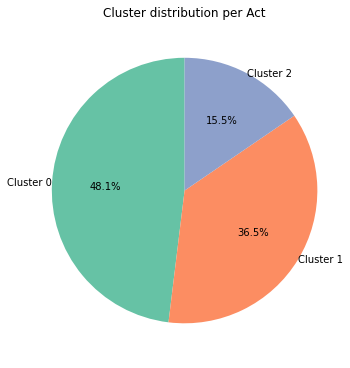

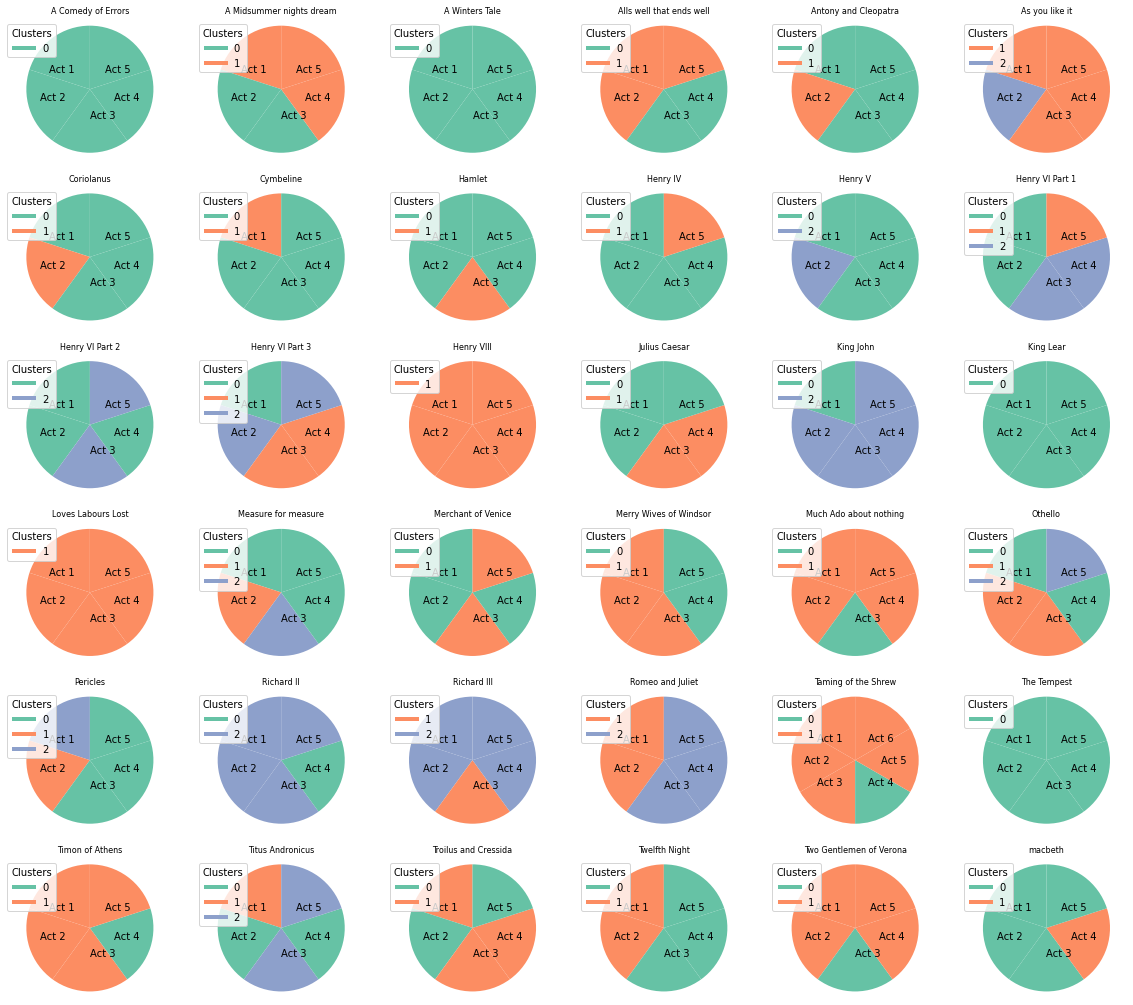

In [166]:
#kmeans_td_idf_clusters_df = get_kmeans_clusters(td_idf_act_dict, k=k, scale=True)
num_kmeans_td_idf_clusters_df = get_kmeans_clusters(num_act_dict, k=k, scale=True)

plot_cluster(num_kmeans_td_idf_clusters_df, k, "Act")

### 3.4.3) Mean Shift using other numerical features (Year, Avg length of sentences, Sentiment)

<span style="color:blue">
We have used another clustering method, Mean Shift, to see how the clustering structure looks like. Mean Shift is returning 6 clusters, but we can see that there is 1 dominant cluster and then another smaller cluster, being the remaining 4 clusters very residual. Again, we found that there are Plays whose Acts are assigned to the same cluster (expected), and other Plays split into 2 clusters. The number of plays including 3 or more clusters is really low. 

In [167]:
def get_mean_shift_clusters(model, bandwidth=1., scale=False):
    lines_df = model['lines_df']
    vec = model['vec']
    if scale:
        vec = preprocessing.scale(vec)
    
    destination = vec

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)#, cluster_all=False)
    ms.fit(destination)

    clusters = ms.labels_
    print(len(np.unique(ms.labels_)))
    lines_df['Cluster'] = clusters
    lines_df['Cluster'] = lines_df['Cluster'].astype(int)
    
    return lines_df  

2


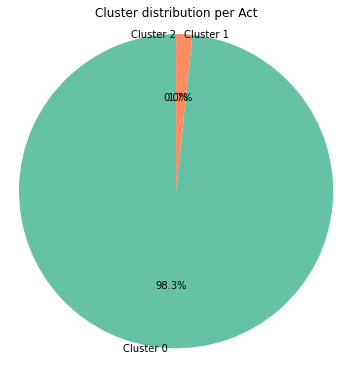

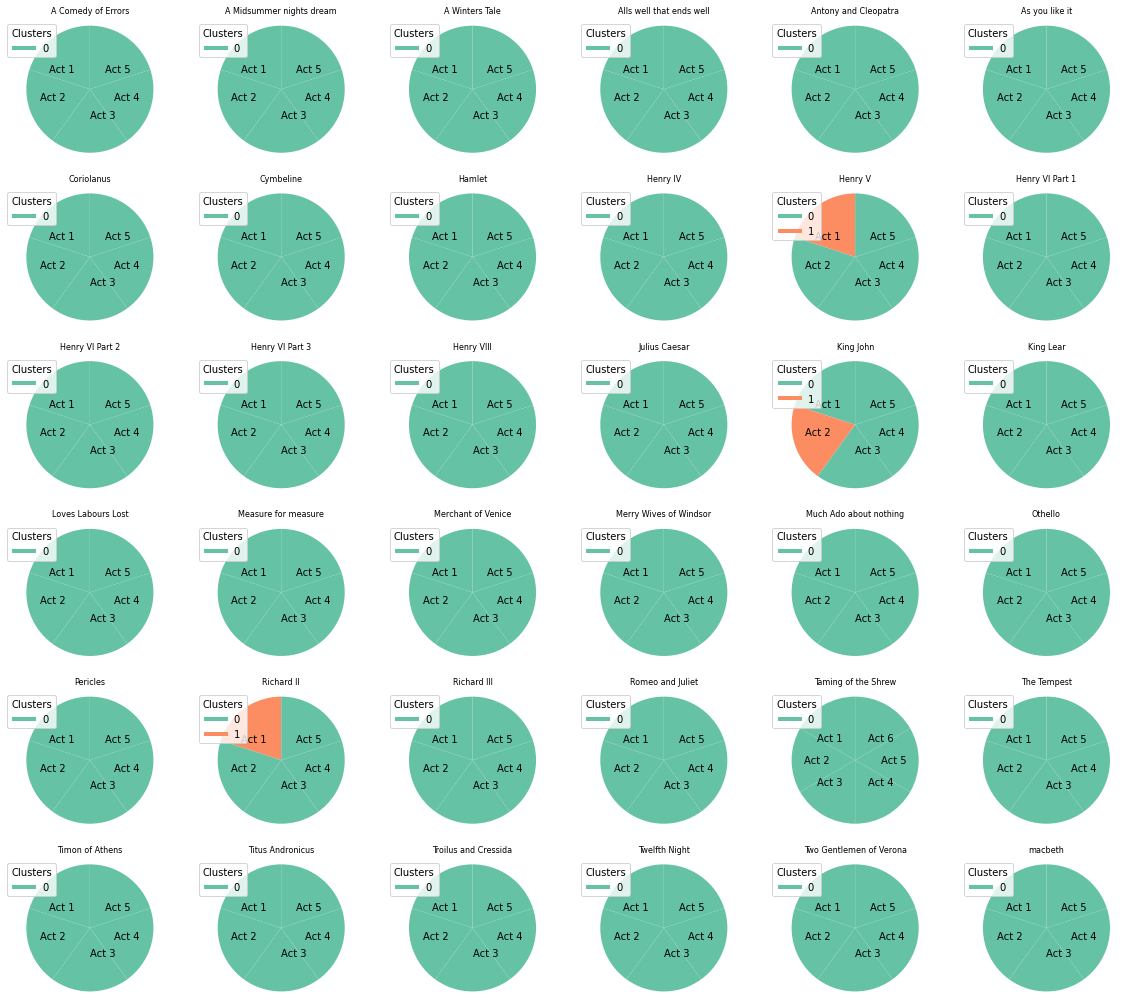

In [168]:
num_mean_shift_df = get_mean_shift_clusters(num_act_dict, bandwidth=9, scale=False)
plot_cluster(num_mean_shift_df, k, "Act")

# 4) Closing Remarks

<span style="color:blue">
    1. Knowing exactly whether or not Shakespeare's plays were written by a genius or a group of people is a very complicated task. At the beginning, we tried several different NLP techniques (including word counts, TF-IDF, LDA, cosine similarity, and so on) to understand the structure and contents in these plays, and also perform some basic supervised learning (classification) using GloVe-based features. Then we used unsupervised learning method (clustering) to explore our initial question that whether one person or a group of people wrote the plays. Indeed we will never know the ground truth to check our model. However, building models that extract clustering structure from the data is possible.<br>
    The PlayerLine is a good source of information that we can use, and we can aggregate (that is, concatenate) the lines at different levels. In this project we analyzed Shakespeare's plays at `Play` and at `Act` level. In both analyses we observed that there are some relatively clear clustering structures. This probably is not enough for us to determine exactly if the plays were written by only one or many people, but it provides us a window to investigate that whether Plays and Acts within the Plays have structures and characteristics that make them belong to different clusters.<br>
    We analyzed the PlayerLines extracting features using `Word2Vec`, `Doc2Vec` and `TD-IDF`. Also, we extracted negative, neutral and positive `Sentiment` and performed clustering analyses. Then we used Agglomerative Hierarchical Clustering, K-Means and Mean Shift to evaluate the clusters. It is interesting that several comedy-tragedy pairs are grouped together as the closet plays in their writting styles. For example, Pericles (comedy) and Hamlet (tragedy), A Midsummer nights dream (comedy) and Troilus and Cressida (tragedy), and so on. This implies that the comedy/tragedy category probably does NOT influence much on our analyses of the styles of plays. Finally, we found that there are consistently 3 to 4 clusters when we use different methods. This implies that it is possible that Plays (and Acts) were written by a group of people rather than one single person. <br>
        <br>
2. Although what I conducted in this final project is an academic study, the methodology and framework (of code) I developed may find practical applications. Maybe we can extend what I did in this project to a useful package for library managers and readers who need to classify book categories. The other possible application is detecting academic misconduct. Directly copying from other people is easy to detect. However, it may be not that easy to detect that someone modifies or replaces some (key) words and/or re-arrange the sentences from others’ papers. With the methodology I proposed above for authorship testing using NLP techniques together with unsupervised learning methods, we may be able to develop an application interface for scholars to check if some suspicious papers are really written by the authors themselves or are simply modified from other people’s papers. The null hypothesis behind this deployment would be that assuming a paper we are going to test is modified from others’ paper(s). Then we test the statistical significance of how the writing styles (i.e., words, sentences, ways of expressing opinions and emotions and so on) of this paper are similar to the writing styles of papers written by other authors. If the statistical significance is low, then we reject the null hypothesis and conclude this suspicious paper is actually unlikely to be written with academic misconduct. If the statistical significance is high, then we fail to reject the null hypothesis and conclude this suspicious paper is likely to be written with academic misconduct. Although this way is definitely not enough to conclude if someone really has academic misconduct or not, it can be used as an auxiliary tool for such detections. 
</span>